# Analysis of renter-occupied households in the American Housing Survey (as modified by the "Data Preparation" Notebook). 

The American Housing Survey (AHS) is being utilized to address the following:
- Increasing the supply of housing at all income levels is one of the leading strategies to solving the housing affordability crisis based on the economic principle that increased supply will reduce demand and alleviate price pressures on housing markets. **What can we observe from the AHS on renter household composition changes, migration trends, and changes in rent in Metropolitan Areas that have contributed more to their overall housing stock?**

It is important to note that there are multiple issues at play when discussing new housing supply and its ability to meet the needs of very-low or extremely-low income households that should not be conflated:
- How much can we expect new housing supply to moderate pressures on rent, especially for low-income households? Does new housing supply lower rents or allow lower-income families to find greater affordability through “filtering” and "moving chains." The evidence is generally "yes", though there needs to be more research on how this varies by geographic context.
    - This analysis of the American Housing Survey (AHS) will help valid this by looking at select metropolitan areas.
        - Atlanta-Sandy Springs-Roswell, GA (12060)
        - Boston-Cambridge-Quincy, MA-NH (14460)
        - Dallas-Fort Worth-Arlington, TX (19100)
        - Houston-The Woodlands-Sugar Land, TX (26420)
        - Phoenix-Mesa-Scottsdale, AZ (38060)
        - Seattle-Tacoma-Bellevue, WA (42660)
        - Washington-Arlington-Alexandria, DC-VA-MD (47900)
        
- How do we expand the supply of subsidized affordable units? Through HUD vouchers? Through LIHTC? Or a different model? This is not a function of "new supply" or rezoning policies, it is a function of subsidy design and implementation, as well as streamlining these subsidy sources. How do we structure subsidies most effectively to ensure that very low and extremely low income households also have access to affordable housing?
    - This analysis of AHS data _**will not**_ address this question. 

#### Using the longitudual data of the American Housing Survey. I will analyze the following:
Identify cohorts of rental units that were occupied by a lower-income household and observe any changes throughout the panel data.

**Research Questions:**
1. How has the (weighted) share of rental units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?
    - Visualize by weighted count as well
2. To what extent does a housing unit stay occupied by an income group over time?
    - The AHS follows "housing units" over time.
3. What is the net flow of movers in and out of the target CBSAs by AMI? 
4. What share of all households exiting CBSAs each year cite housing costs as a reason? Among 2015 renters, who exited and cited high housing costs? Are certain AMI groups leaving CBSAs at a higher rate because of housing costs?
    - Was the units replaced by someonw with a higher income? 
        - **Note:** Not answered at this time. May include in future analysis
5. What about the inverse? Who is moving into these CBSAs to reduce housing costs? Area certain AMI groups moving _into_ a CBSA at a higher rate for housing affordability?
6. Changes in rent for renter-occpuied households of market-rate units (i.e., unsubsidized, not income-restricted housing)
    - How have rents changed for lower income households (<= 80% AMI) in relation to higher income households (>80 AMI)? 
    - What is the percent change of rent for households in each income group over time (2015-2023)?
    - Are rent increases higher for ELI, LI, or LI renters than for higher-income renters?

In [1]:
#Importing Libraries
import requests
from io import StringIO

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [2]:
#Loading 2023 AHS METRO PUF w/ selected columns
metro_rent_ami_df = pd.read_csv('/Volumes/LaCie/GCPI 2025 Visiting Fellowship/Policy Brief 1/Data/metro_rent_ami_df.csv')
metro_rent_ami_df.head()

,CONTROL,RENT,RMCOSTS,TENURE,RENTCNTRL,RENTSUB,OMB13CBSA,WEIGHT,NUMPEOPLE,HUDSUB,...,l80_3,l80_4,l80_5,l80_6,l80_7,l80_8,ELI_threshold,VLI_threshold,LI_threshold,AMI
0,11000095,5100,2,2,2,8,47900,1594.608461,3,3,...,85800,95300,102950,110550,118200,125800,40700.0,67850.0,85800.0,Above LI
1,11000127,250,-6,2,-6,4,47900,449.020746,2,1,...,85800,95300,102950,110550,118200,125800,36200.0,60300.0,76250.0,ELI
2,11000152,1200,-6,2,-6,5,47900,1294.500241,3,3,...,85800,95300,102950,110550,118200,125800,40700.0,67850.0,85800.0,VLI
3,11000157,1100,-6,2,1,8,47900,935.650260,1,3,...,85800,95300,102950,110550,118200,125800,31650.0,52750.0,66750.0,Above LI
4,11000173,1600,-6,2,2,8,47900,935.650260,1,3,...,85800,95300,102950,110550,118200,125800,31650.0,52750.0,66750.0,Above LI


In [3]:
#Inspecting the shape/info of the stacked DataFrame
print(metro_rent_ami_df.shape)
print(metro_rent_ami_df.info())

(27769, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CONTROL         27769 non-null  int64  
 1   RENT            27769 non-null  int64  
 2   RMCOSTS         27769 non-null  int64  
 3   TENURE          27769 non-null  int64  
 4   RENTCNTRL       27769 non-null  int64  
 5   RENTSUB         27769 non-null  int64  
 6   OMB13CBSA       27769 non-null  int64  
 7   WEIGHT          27769 non-null  float64
 8   NUMPEOPLE       27769 non-null  int64  
 9   HUDSUB          27769 non-null  int64  
 10  HINCP           27769 non-null  int64  
 11  SRVYEAR         27769 non-null  int64  
 12  hud_area_code   27769 non-null  object 
 13  hud_area_name   27769 non-null  object 
 14  il_fiscal_year  27769 non-null  int64  
 15  median_income   27769 non-null  int64  
 16  l50_1           27769 non-null  int64  
 17  l50_2           277

In [4]:
#Creating function to change columns back to their original dtype
def convert_columns_to_string(df, columns):
    """
    Convert specified columns in a DataFrame to string (object) dtype.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify
    columns (list of str): List of column names to convert

    Returns:
    pd.DataFrame: DataFrame with specified columns converted to string
    """
    df = df.copy()  # Avoid modifying original DataFrame
    for col in columns:
        df[col] = df[col].astype(str)
    return df

In [5]:
#Usage:
columns = ['CONTROL', 'RMCOSTS', 'TENURE', 'RENTCNTRL', 'RENTSUB', 'OMB13CBSA', 'HUDSUB']
metro_rent_ami_df = convert_columns_to_string(metro_rent_ami_df, columns)

**Note:** I am not reverting `'SRVYEAR'` or `'il_fiscal_year'` back to a string value becuase that will cause errors in the defined functions below.

In [6]:
#re-inspecting DataFrame
print(metro_rent_ami_df.shape)
print(metro_rent_ami_df.info())

(27769, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CONTROL         27769 non-null  object 
 1   RENT            27769 non-null  int64  
 2   RMCOSTS         27769 non-null  object 
 3   TENURE          27769 non-null  object 
 4   RENTCNTRL       27769 non-null  object 
 5   RENTSUB         27769 non-null  object 
 6   OMB13CBSA       27769 non-null  object 
 7   WEIGHT          27769 non-null  float64
 8   NUMPEOPLE       27769 non-null  int64  
 9   HUDSUB          27769 non-null  object 
 10  HINCP           27769 non-null  int64  
 11  SRVYEAR         27769 non-null  int64  
 12  hud_area_code   27769 non-null  object 
 13  hud_area_name   27769 non-null  object 
 14  il_fiscal_year  27769 non-null  int64  
 15  median_income   27769 non-null  int64  
 16  l50_1           27769 non-null  int64  
 17  l50_2           277

## General Helper Functions
I am creating two (2) global helper functions that will be used in each analysis:
- Incorporating the `'WEIGHT'` variable
    - `w_mean` function to calucate the weighted mean of a variable
    - `w_sum` function to calucation the wieghted sum of a variable
    - `weighted_mean_by_group` function to calculate a weighted mean by a group of variables (i.e., Metro Area, Year)
    - `weighted_count_by_group` function to calculate a weighted count by a group of variables (i.e., Metro Area, Year)
- Mapping to Metro Areas by CBSA Code 
    - `create_cbsa_name_mapping()` provide a **hardcoded**, readable mapping of CBSA codes to metro names.
        - Returns a dictionary of `'OMB13CBSA'` variables to readable/user friendly metro names.
        - **Note:** The `metro_rent_ami_df` DataFrame only contains the target metro areas listed above so it is not necessary at this point. However, if future analysis call for national comparisons this function will help isolate analyses to the select metros when needed.

### Weighting: First Approach for Means and Total Counts

The cell below is a set of code where I define two separate "helper" functions.  The first is to calculate a weighted mean, the second is to create a weighted sum. Use the `w_mean` and `w_sum` functions in cells to specify the weighted output.  

In [7]:
#Helper function for weighted mean.
def w_mean(df, val_col, wt_col):
    w = df[wt_col]
    if w.sum() == 0 or w.isna().all():
        return np.nan
    return np.average(df[val_col], weights=w)

#Helper function for weighted sum.
def w_sum(df, val_col, wt_col):
    product = df[val_col] * df[wt_col]
    return product.sum() if not product.empty else np.nan

In [8]:
#Weighted Stats by Group. The functions below provide weighted means or totals **by metro area or year**.

#Weight mean by group
def weighted_mean_by_group(df, group_cols, val_col, wt_col='WEIGHT'):
    return (
        df.groupby(group_cols)
        .apply(lambda g: np.average(g[val_col], weights=g[wt_col]))
        .reset_index(name=f'{val_col}_weighted_mean')
    )

#Weighted sum by group
def weighted_count_by_group(df, group_cols, wt_col='WEIGHT'):
    return (
        df.groupby(group_cols)[wt_col]
        .sum()
        .reset_index(name='weighted_count')
    )

In [9]:
#Preview Function Usage

#Examining the weighted count of households within each AMI group.
weighted_count_by_group(metro_rent_ami_df, ['SRVYEAR', 'OMB13CBSA', 'AMI'])

,SRVYEAR,OMB13CBSA,AMI,weighted_count
0,2015,12060,Above LI,290971.752169
1,2015,12060,ELI,153274.661403
2,2015,12060,LI,141143.800227
3,2015,12060,VLI,111010.645216
4,2015,14460,Above LI,289377.108574
...,...,...,...,...
135,2023,42660,VLI,109114.289454
136,2023,47900,Above LI,392196.353389
137,2023,47900,ELI,220027.267528
138,2023,47900,LI,74790.383770


In [10]:
#Examining the weighted average household income based on AMI classification
weighted_mean_by_group(metro_rent_ami_df, ['SRVYEAR', 'OMB13CBSA', 'AMI'], 'HINCP')

,SRVYEAR,OMB13CBSA,AMI,HINCP_weighted_mean
0,2015,12060,Above LI,85727.502767
1,2015,12060,ELI,9264.741574
2,2015,12060,LI,37599.953128
3,2015,12060,VLI,22863.747043
4,2015,14460,Above LI,113649.363734
...,...,...,...,...
135,2023,42660,VLI,44818.520815
136,2023,47900,Above LI,159487.620575
137,2023,47900,ELI,18178.648074
138,2023,47900,LI,67759.939835


### Establishing the  `create_cbsa_name_mapping()` function
- **Goal:** Provide a hardcoded, readable mapping of CBSA codes to names.
- **Returns:** dict of `'OMB13CBSA'` → Metro names.

In [11]:
def create_cbsa_name_mapping():
    """
    Create a mapping from CBSA codes to readable names.
    
    Return a stable mapping from CBSA codes (OMB13CBSA) to consistent, readable metro names.
    
    Returns:
    Dictionary mapping CBSA codes (as strings) to user-friendly names
    """
    
    #Default mapping for common CBSAs
    return {
        '47900': "Washington-Arlington-Alexandria, DC-VA-MD",
        '14460': "Boston-Cambridge-Quincy, MA-NH",
        '19100': "Dallas-Fort Worth-Arlington, TX",
        '26420': "Houston-The Woodlands-Sugar Land, TX",
        '38060': "Phoenix-Mesa-Scottsdale, AZ",
        '42660': "Seattle-Tacoma-Bellevue, WA",
        '12060': "Atlanta-Sandy Springs-Roswell, GA"
    }

## Quick check on sample size of the same households (unique `'CONTROL'` number) that appear in every wave/year of the survey

In [12]:
#Checking the size of the sample for unique housing units interviewed in every survey year
controls_in_all_years = (
    metro_rent_ami_df[['CONTROL', 'SRVYEAR']]
    .drop_duplicates().
    groupby('CONTROL')['SRVYEAR'].nunique()
    .loc[lambda x: x == metro_rent_ami_df['SRVYEAR'].nunique()]
    .index
)

In [13]:
len(controls_in_all_years)

#Looking at the actual CONTROL values that persist across all years
#print(controls_in_all_years.tolist())

1026

### Creating a DataFrame that _only_ consists of renter occupied housng units (unique `'CONTROL'` numbers) that are present in the data for every wave of the survey (`'SRVYEAR'`). 

In [14]:
full_panel_hh_df = metro_rent_ami_df.loc[
    metro_rent_ami_df['CONTROL'].isin(controls_in_all_years)
].copy()

In [15]:
#Chcking the code for the DataFrame worked correctly
print(full_panel_hh_df['CONTROL'].nunique())  # Should match len(controls_in_all_years)
print(full_panel_hh_df['SRVYEAR'].nunique())  # Should equal number of survey years (e.g., 5)

1026
5


In [16]:
#Looking at `CONTROL` numbers that changed metro areas
metro_change_counts = (
    full_panel_hh_df[['CONTROL', 'OMB13CBSA']]
    .drop_duplicates()
    .groupby('CONTROL')['OMB13CBSA']
    .nunique()
)

In [17]:
metro_change_counts.value_counts()

1    1026
Name: OMB13CBSA, dtype: int64

Sample size for full-panel units is 1,026

In [18]:
#CONTROLs that changed metro areas at least once
movers = metro_change_counts[metro_change_counts > 1].index
len(movers)

0

Appears as though renter-occupied housing units (unique `'CONTROL'` numbers) that are present in every wave/year **_do not_** change CBSAs/metro areas over time. 

## 1(a). How has the (weighted) share of rental units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?
### 1(b). How has the (weighted) share of rental units occupied by LI/VLI/ELI households changed from 2015 - 2023 in select metro areas?

The line graph will show the change in the share of renter households from 2015 - 2023 by AMI.

In [19]:
#Define AMI category order
ami_order = ['Above LI', 'LI', 'VLI', 'ELI']
metro_rent_ami_df['AMI'] = pd.Categorical(metro_rent_ami_df['AMI'], categories=ami_order, ordered=True)

In [20]:
#Weighted count of households by year, AMI, and CBSA
ami_weighted = (
    metro_rent_ami_df
    .groupby(['SRVYEAR', 'AMI', 'OMB13CBSA'])['WEIGHT']
    .sum()
    .reset_index(name='weighted_count')
)

In [21]:
#Total weighted households per year and CBSA
total_weighted = (
    ami_weighted
    .groupby(['SRVYEAR', 'OMB13CBSA'])['weighted_count']
    .sum()
    .reset_index(name='total_weighted')
)

In [22]:
#Merge
ami_share = pd.merge(ami_weighted, total_weighted, on=['SRVYEAR', 'OMB13CBSA'])

In [23]:
#Filter only rows with valid AMI and CBSA mapping
cbsa_map = create_cbsa_name_mapping()
ami_share = ami_share[ami_share['AMI'].notna() & ami_share['OMB13CBSA'].isin(cbsa_map.keys())]

In [24]:
#Calculate share
ami_share['share'] = ami_share['weighted_count'] / ami_share['total_weighted']
ami_share['Metro'] = ami_share['OMB13CBSA'].map(cbsa_map)
ami_share['AMI'] = pd.Categorical(ami_share['AMI'], categories=ami_order, ordered=True)

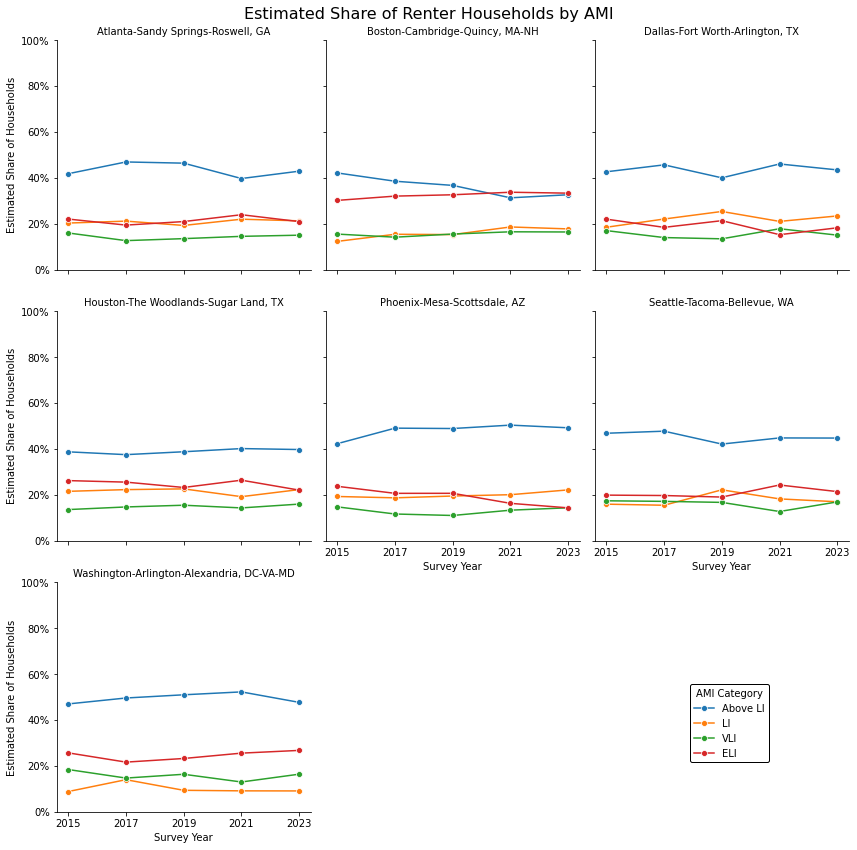

In [25]:
#Plot weighted share
g = sns.FacetGrid(
    ami_share,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='share', marker='o')

#Format plot axes and labels
g.set_axis_labels('Survey Year', 'Estimated Share of Households')
g.set_titles(col_template="{col_name}")
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

#Set consistent legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI Category",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.9, 0.1)
)

#Remove redundant legends from individual facets
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Estimated Share of Renter Households by AMI', fontsize=16)

actual_years = [2015, 2017, 2019, 2021, 2023]
g.set(xticks=actual_years)

#Save and export image as png file
#g.savefig('estimated_share_renter_households_by_AMI.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

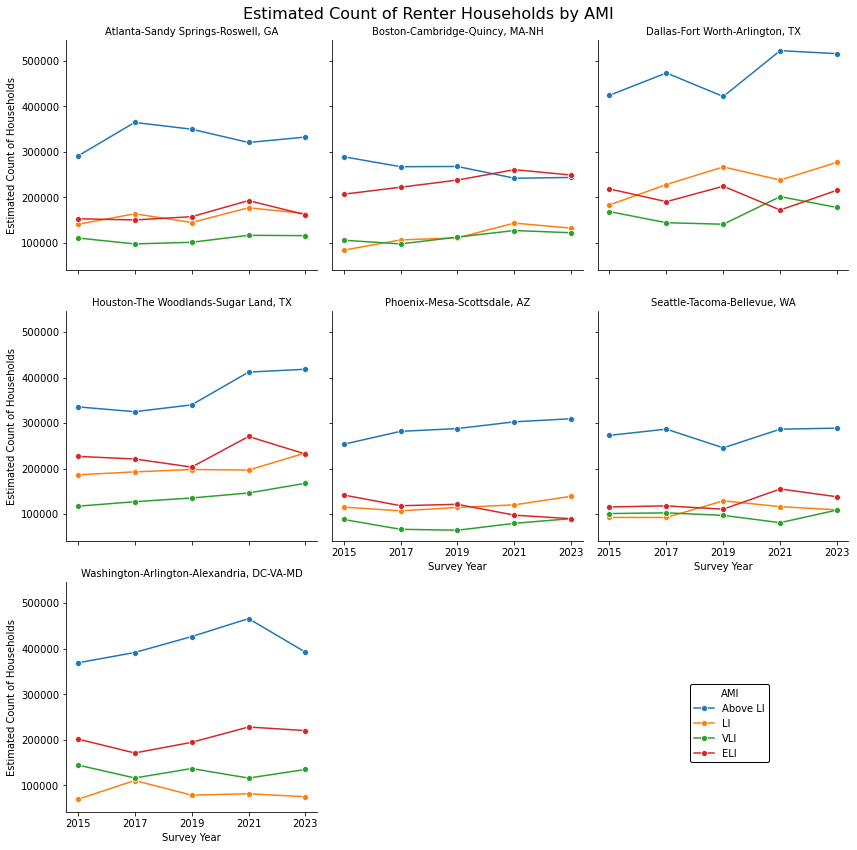

In [26]:
#plotting weighted count
g = sns.FacetGrid(
    ami_share,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='weighted_count', marker='o')

#Format plot axes and labels
g.set_axis_labels('Survey Year', 'Estimated Count of Households')
g.set_titles(col_template="{col_name}")

#Set consistent legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.9, 0.1)
)

#Remove redundant legends from individual facets
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Estimated Count of Renter Households by AMI', fontsize=16)

actual_years = [2015, 2017, 2019, 2021, 2023]
g.set(xticks=actual_years)

#Save and export image as png file
#g.savefig('estimated_count_renter_households_by_AMI.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 2(a). Examining how the occupancy of rental housing units have changed for a partial-panel (units -`'CONTROL'`- present in 2015 and 2023 only). Do rental housing units that start as a "higher income" unit - measured by AMI - tend to stay high income occupied (even if the household changes) for this partial-panel of units?

The partial-panel analysis shows how the distribution of renters by AMI changes in a unit between two time points - capturing turnover, filtering, and affordability shifts.

- This analysis looks at a larger smaple of units that include any rental unit observed in both "anchor years," even if it was not observed (or occupied) in intermediate waves.
- The partial-panel reflects turnover in who lives in a unit - a unit may transition from a VLI renter in 2015 to an Above LI renter in 2023.
- Observes who the housing stock has served over time, regardless of household continuity.
- Observes changing affordability or income sorting of the housing stock.

In [27]:
#Filter for 2015 and 2023 renters only
df_15 = metro_rent_ami_df[metro_rent_ami_df['SRVYEAR'] == 2015].copy()
df_23 = metro_rent_ami_df[metro_rent_ami_df['SRVYEAR'] == 2023].copy()

The filtering above **_does not_** limit this analysis to households that were present in every year of the survey — it only ensures the household (`'CONTROL'`) was present in 2015 and 2023, and that it remained in the same CBSA.
- The code above isolates households present in 2015 and in 2023, but not 2017, 2019, or 2021.

In [28]:
#Merge on CONTROL to track households over time
merged = pd.merge(
    df_15[['CONTROL', 'OMB13CBSA', 'AMI', 'WEIGHT']],
    df_23[['CONTROL', 'OMB13CBSA', 'AMI', 'WEIGHT']],
    on='CONTROL',
    suffixes=('_15', '_23')
)

- This code limits this analysis to just households present **in both 2015 and 2023**.

In [29]:
#Keep households that remained in the same CBSA
stable = merged[merged['OMB13CBSA_15'] == merged['OMB13CBSA_23']].copy()
stable['Metro'] = stable['OMB13CBSA_15'].map(cbsa_map) 

- This keeps onlt households that **did not move metro areas** between 2015 and 2023.

In [30]:
#Filter for metros of interest
stable = stable[stable['Metro'].notna()]
stable['AMI_15'] = pd.Categorical(stable['AMI_15'], categories=ami_order, ordered=True) 
stable['AMI_23'] = pd.Categorical(stable['AMI_23'], categories=ami_order, ordered=True) 

In [31]:
len(stable)

2457

Sample size for partial panel

In [32]:
#Transition matrix: overall weighted counts
transition_matrix = (
    stable
    .groupby(['AMI_15', 'AMI_23'])['WEIGHT_23']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=ami_order, columns=ami_order)
)

- The transition matrix includes partial panels, not just complete ones.

In [33]:
#Normalize by row to get share
transition_percent = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

In [34]:
#Print Results
print('Weighted Partial-Panel Rental Unit Transitions (2015 to 2023) - Overall:')
print(transition_matrix.round(0).astype(int))

print('\n Share of Partial-Panel 2015 Rental Units by 2023 AMI - Overall (%):')
print((transition_percent * 100).round(1))

Weighted Partial-Panel Rental Unit Transitions (2015 to 2023) - Overall:
AMI_23    Above LI      LI     VLI     ELI
AMI_15                                    
Above LI    753819  250112  168855  175295
LI          202202  130340   87622  133143
VLI         140343   99674  124096  139318
ELI         143710  132262  161655  266683

 Share of Partial-Panel 2015 Rental Units by 2023 AMI - Overall (%):
AMI_23    Above LI    LI   VLI   ELI
AMI_15                              
Above LI      55.9  18.6  12.5  13.0
LI            36.5  23.6  15.8  24.1
VLI           27.9  19.8  24.7  27.7
ELI           20.4  18.8  23.0  37.9


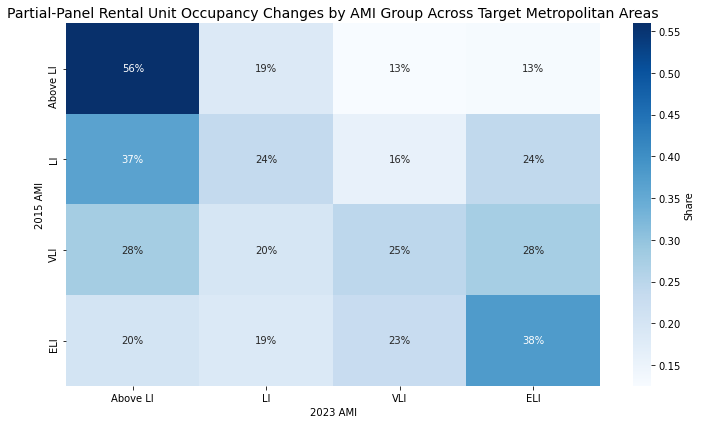

In [35]:
#plot via heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    transition_percent,
    annot=True,
    cmap='Blues',
    fmt='.0%',
    cbar_kws={'label': 'Share'}
)
plt.title('Partial-Panel Rental Unit Occupancy Changes by AMI Group Across Target Metropolitan Areas', fontsize=14)
plt.xlabel('2023 AMI')
plt.ylabel('2015 AMI')

#Save and export image as png file
#plt.savefig('partial_panel_rental_unit_change_ami.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 2(b). Partial-panel rental unit occupancy transitions by AMI and metro

In [36]:
#Metro-level transitions
metro_transitions = (
    stable
    .groupby(['Metro', 'AMI_15', 'AMI_23'])['WEIGHT_23']
    .sum()
    .reset_index(name='weighted_count')
)

In [37]:
#Calculate share within each (Metro, AMI_15) group
metro_transitions['total'] = metro_transitions.groupby(['Metro', 'AMI_15'])['weighted_count'].transform('sum')
metro_transitions['share'] = metro_transitions['weighted_count'] / metro_transitions['total']

In [38]:
#Ensure categorical AMI order
metro_transitions['AMI_15'] = pd.Categorical(metro_transitions['AMI_15'], categories=ami_order, ordered=True)
metro_transitions['AMI_23'] = pd.Categorical(metro_transitions['AMI_23'], categories=ami_order, ordered=True)

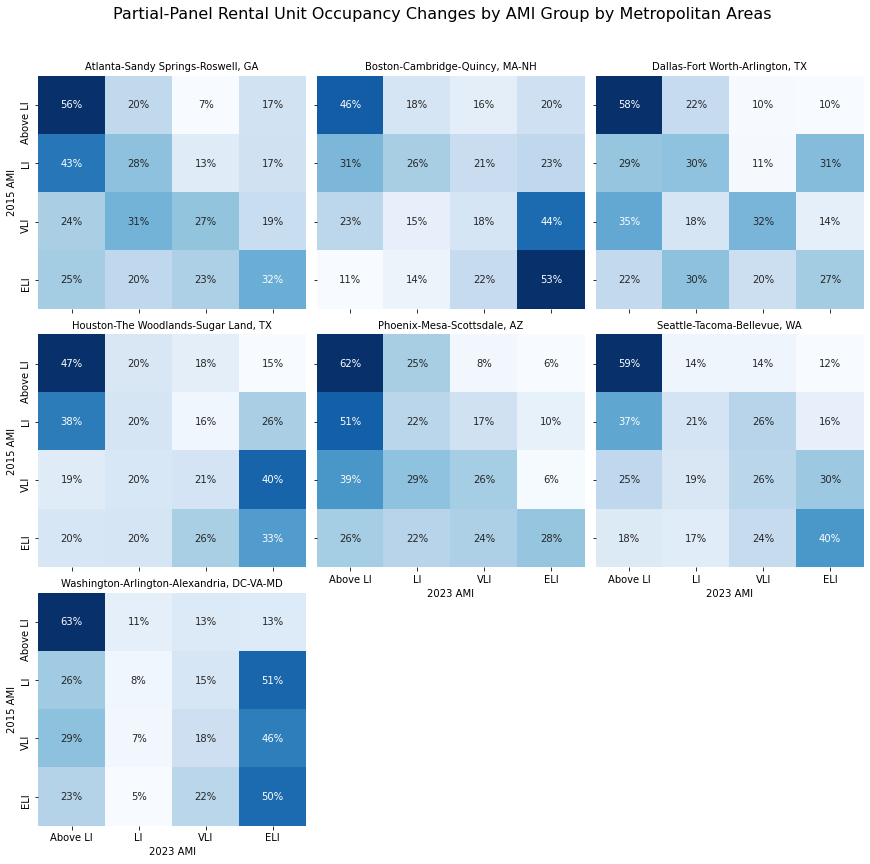

In [39]:
#Plot via Heatmap
g = sns.FacetGrid(
    metro_transitions,
    col='Metro',
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

def heatmap(data, **kwargs):
    pivot = data.pivot(index='AMI_15', columns='AMI_23', values='share').fillna(0)
    pivot = pivot.reindex(index=ami_order, columns=ami_order)
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.0%',
        cmap='Blues',
        cbar=False,
        **kwargs
    )

g.map_dataframe(heatmap)
g.set_titles('{col_name}')

#Manually assign axis labels only where needed
for i, ax in enumerate(g.axes.flatten()):
    if i not in [0, 1, 2, 3]:  #Only keep x-labels on lower row except col 1+2 top
        ax.set_xlabel('2023 AMI')
    else:
        ax.set_xlabel('')

    if i not in [1, 2, 4, 5]:  #Only keep y-labels on leftmost column
        ax.set_ylabel('2015 AMI')
    else:
        ax.set_ylabel('')

#Adjust spacing and add shared title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Partial-Panel Rental Unit Occupancy Changes by AMI Group by Metropolitan Areas", fontsize=16)

#Save and export image as png file
#g.savefig('partial_panel_rental_unit_change_ami_by_metro.png', dpi=300, bbox_inches='tight')

plt.show()

## 2(c). Examining how the occupancy of rental housing units have changed for the full-panel (units present in all survey years). Do rental housing units that start as a "higher income" unit - measured by AMI - tend to stay high income occupied (even if the household changes)?

The full-panel analysis shows how the income profile of a continuously-survey unit evolves over time - better for understanding gradual affordability change or persistent occupancy by a particular AMI group. 

- This analysis is observing the **same unit** at multple pooints, allowing for true time-series comparison of occupancy by AMI level.
- AMI transitions in these units more likely reflect true affordability changes rather than random fluctuations in hwo moved in or out.
- This directly measures whether a unit once occupied by a lower-income renters is now housing high-income renters (or vice versa).

In [40]:
#Filter for 2015 and 2023 full-panel renters only
full_df_15 = full_panel_hh_df[full_panel_hh_df['SRVYEAR'] == 2015].copy()
full_df_23 = full_panel_hh_df[full_panel_hh_df['SRVYEAR'] == 2023].copy()

In [41]:
#Merge on CONTROL to track households over time
merged_full = pd.merge(
    full_df_15[['CONTROL', 'OMB13CBSA', 'AMI', 'WEIGHT']],
    full_df_23[['CONTROL', 'OMB13CBSA', 'AMI', 'WEIGHT']],
    on='CONTROL',
    suffixes=('_15', '_23')
)

In [42]:
#Keep households that remained in the same CBSA
stable_full = merged_full[merged_full['OMB13CBSA_15'] == merged_full['OMB13CBSA_23']].copy()
stable_full['Metro'] = stable_full['OMB13CBSA_15'].map(cbsa_map) 

In [43]:
#Filter for metros of interest
stable_full = stable_full[stable_full['Metro'].notna()]
stable_full['AMI_15'] = pd.Categorical(stable_full['AMI_15'], categories=ami_order, ordered=True) 
stable_full['AMI_23'] = pd.Categorical(stable_full['AMI_23'], categories=ami_order, ordered=True) 

In [44]:
#Transition matrix: overall weighted counts
transition_matrix_full = (
    stable_full
    .groupby(['AMI_15', 'AMI_23'])['WEIGHT_23']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=ami_order, columns=ami_order)
)

In [45]:
#Normalize by row to get share
transition_percent_full = transition_matrix_full.div(transition_matrix_full.sum(axis=1), axis=0)

In [46]:
#Print Results
print("Weighted Full-Panel Rental Unit Transitions (2015 to 2023) - Overall:")
print(transition_matrix_full.round(0).astype(int))

print("\n Share of Full-Panel 2015 Rental Units by 2023 AMI - Overall (%):")
print((transition_percent_full * 100).round(1))

Weighted Full-Panel Rental Unit Transitions (2015 to 2023) - Overall:
AMI_23    Above LI     LI    VLI     ELI
AMI_15                                  
Above LI    299827  92973  71400   67741
LI           62434  38875  33019   60833
VLI          53193  45532  52587   65662
ELI          55321  45157  55077  133927

 Share of Full-Panel 2015 Rental Units by 2023 AMI - Overall (%):
AMI_23    Above LI    LI   VLI   ELI
AMI_15                              
Above LI      56.4  17.5  13.4  12.7
LI            32.0  19.9  16.9  31.2
VLI           24.5  21.0  24.2  30.3
ELI           19.1  15.6  19.0  46.3


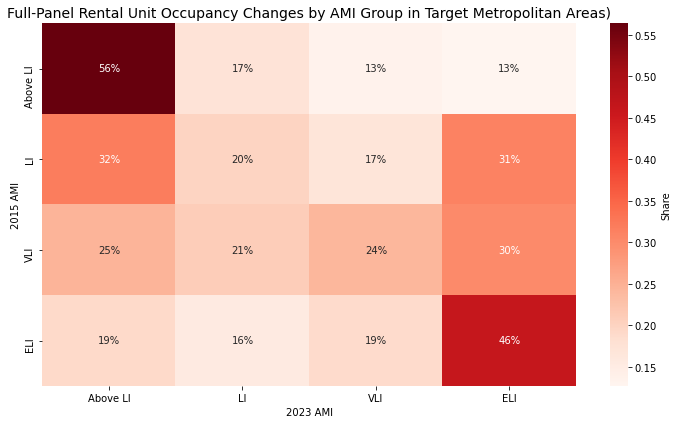

In [47]:
#plot via heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    transition_percent_full,
    annot=True,
    cmap='Reds',
    fmt='.0%',
    cbar_kws={'label': 'Share'}
)
plt.title("Full-Panel Rental Unit Occupancy Changes by AMI Group in Target Metropolitan Areas)", fontsize=14)
plt.xlabel("2023 AMI")
plt.ylabel("2015 AMI")

#Save and export image as png file
#plt.savefig('full_panel_rental_unit_change_ami.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

## 2(d). Full-panel rental unit occupancy transitions by AMI and metro

In [48]:
#Metro-level transitions
metro_transitions_full = (
    stable_full
    .groupby(['Metro', 'AMI_15', 'AMI_23'])['WEIGHT_23']
    .sum()
    .reset_index(name='weighted_count')
)

In [49]:
#Calculate share within each (Metro, AMI_15) group
metro_transitions_full['total'] = metro_transitions_full.groupby(['Metro', 'AMI_15'])['weighted_count'].transform('sum')
metro_transitions_full['share'] = metro_transitions_full['weighted_count'] / metro_transitions_full['total']

In [50]:
#Ensure categorical AMI order
metro_transitions_full['AMI_15'] = pd.Categorical(metro_transitions_full['AMI_15'], categories=ami_order, ordered=True)
metro_transitions_full['AMI_23'] = pd.Categorical(metro_transitions_full['AMI_23'], categories=ami_order, ordered=True)

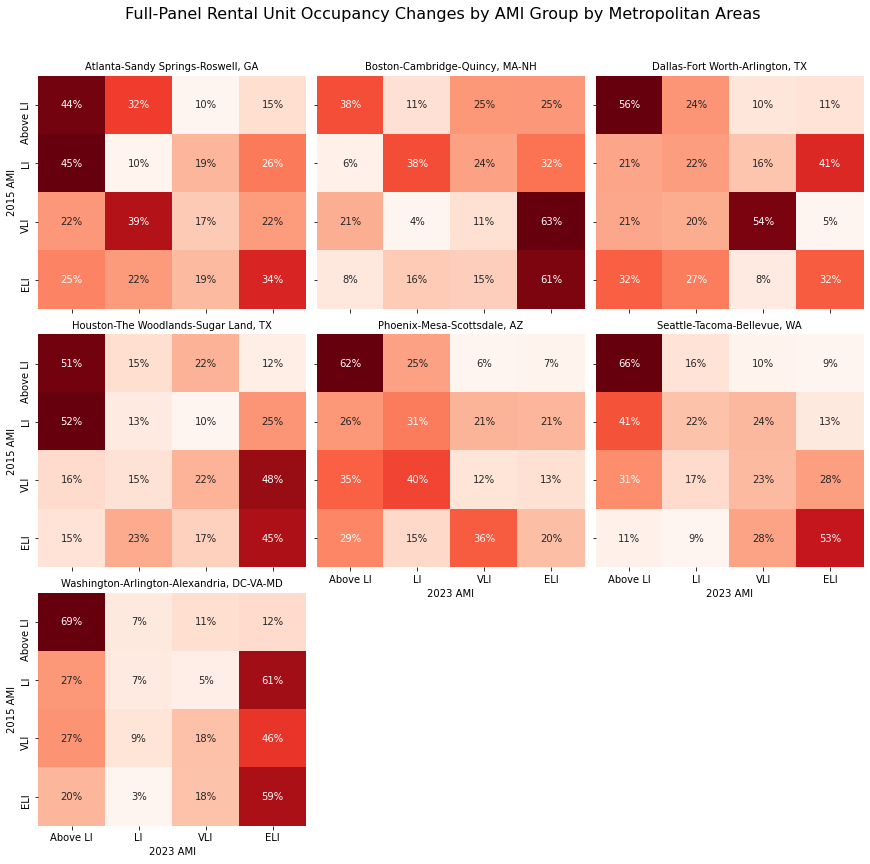

In [51]:
#Plot via Heatmap
g = sns.FacetGrid(
    metro_transitions_full,
    col='Metro',
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

def heatmap(data, **kwargs):
    pivot = data.pivot(index='AMI_15', columns='AMI_23', values='share').fillna(0)
    pivot = pivot.reindex(index=ami_order, columns=ami_order)
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.0%',
        cmap='Reds',
        cbar=False,
        **kwargs
    )

g.map_dataframe(heatmap)
g.set_titles('{col_name}')

#Manually assign axis labels only where needed
for i, ax in enumerate(g.axes.flatten()):
    if i not in [0, 1, 2, 3]:  #Only keep x-labels on lower row except col 1+2 top
        ax.set_xlabel('2023 AMI')
    else:
        ax.set_xlabel('')

    if i not in [1, 2, 4, 5]:  #Only keep y-labels on leftmost column
        ax.set_ylabel('2015 AMI')
    else:
        ax.set_ylabel('')

#Adjust spacing and add shared title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Full-Panel Rental Unit Occupancy Changes by AMI Group by Metropolitan Areas", fontsize=16)

#Save and export image as png file
#g.savefig('full_panel_rental_unit_change_ami_by_metro.png', dpi=300, bbox_inches='tight')

plt.show()

## 3(a). What is the net flow of movers in and out of the target CBSAs by AMI?  

Exmining the genereal flow of entries/exits into the target CBSAs, disaggreated by AMI. 
Tracking the **net flows (entries minus exits)** by `'AMI'` may help describe how renter composition is changing across income levels within each metro.

Computing:
1. **Total weighted entries** per Metro-Year-AMI
2. **Total weighted exits** per Metro-Year-AMI
3. Join the two and calculate:
    - `net_flow = entries - extis`
    - `net_share = (entries - exits) / total renter population`

**Conceptual Plan**
1. Use both entry and exit functions to identify unique CONTROLs and their entry or exit years and metro areas.
2. Merge in `'AMI'` and `'WEIGHT'` for those years.
3. For each `'OMB13CBSA'` and year:
    - Compute total renter household count (weighted) for baseline denominator.
    - Compute entries and exits by `'AMI'` as a share of that base.
4. Plot shares of movers (entries or exits) by `'AMI'` over time.
5. Use FacetGrid with one subplot per metro.

#### Create `find_household_exits(df)` & `find_household_entries(df)` functions
- **Goal:** Identify households that entered and/or left the survey panel.
- **How:**
    - Tracks all survey years (`'SRVYEAR'`) for each unique household (`'CONTROL'`).
    - Computes the last year present and determines the first year after (i.e., the "exit") and identifies when unique households (`'CONTROL'`) first appear in the survey and the CBSA they entered.
    - `find_household_exits(df)` **Returns:** `'CONTROL'`, `'last_year_present'`, `'exit_year'`, and `'last_cbsa'`.
    - `find_household_entries(df)` **returns** `'CONTROL'`, `'first_year_present'`, `'entry_cbsa'`

In [52]:
def find_household_exits(df):
    """
    Identify the year and CBSA in which unique households exit the panel (i.e., are not observed after a given year).
    Excludes exits in the final survey year (2023).
    """
    
    #Setting the bounds of the panel data so 2023 is excluded from "exits"
    all_years = sorted(df['SRVYEAR'].unique())
    max_year = all_years[-1]

    # Get last year per household
    last_seen = (
        df.sort_values(['CONTROL', 'SRVYEAR'])
        .drop_duplicates('CONTROL', keep='last')
        [['CONTROL', 'SRVYEAR', 'OMB13CBSA']]
        .rename(columns={'SRVYEAR': 'last_year_present', 'OMB13CBSA': 'last_cbsa'})
    )

    # Compute exit year
    last_seen['exit_year'] = last_seen['last_year_present'].apply(
        lambda y: min([yr for yr in all_years if yr > y], default=None)
    )

    # Keep only those who exited before the final year
    exits_df = last_seen[last_seen['last_year_present'] < max_year].copy()
    
    return exits_df[['CONTROL', 'last_year_present', 'exit_year', 'last_cbsa']].sort_values('exit_year')

In [53]:
def find_household_entries(df):
    """
    Identify the year and CBSA in which unique households enter the panel.
    Excludes households present in the first panel year (2015).
    """
    
    #Setting the bounds of the panel data so 2015 is excluded from "entries"
    all_years = sorted(df['SRVYEAR'].unique())
    min_year = all_years[0]

    # Get first year per household
    first_seen = (
        df.sort_values(['CONTROL', 'SRVYEAR'])
        .drop_duplicates('CONTROL', keep='first')
        [['CONTROL', 'SRVYEAR', 'OMB13CBSA']]
        .rename(columns={'SRVYEAR': 'first_year_present', 'OMB13CBSA': 'entry_cbsa'})
    )

    #Keep only new entrants (after base year)
    entries_df = first_seen[first_seen['first_year_present'] > min_year].copy()
    
    return entries_df[['CONTROL', 'first_year_present', 'entry_cbsa']].sort_values('first_year_present')

After the calculation and plotting of net household migration by household income, the `'RMCOSTS'` variable will be incoporated to show the wieghted percentage (using the `'WEIGHT'` variable) of households that moved to or moved from a CBSA to reduce housing costs, disaggregated by `'AMI'`. 

The `'RMCOSTS'` variable is a flag indicating that the survey respondent, who moved in last two years, moved to reduce housing costs (1 = yes, 2 = no). There are other values that are not relevant (`N `or '`-6`, `M` or `-9`). 

The following `add_housing_cost_info_exits(exits_df, original_df)` and `add_housing_cost_info_entries(entries_df, original_df)` functions are need to bring in the variables needed for the net migration analysis and will also be used later to observe migration due to housing costs.

#### Create `add_housing_cost_info_exits(exits_df, original_df)` and `add_housing_cost_info_entries(entries_df, original_df)` functions
- **Goal:** Join `RMCOSTS`, `WEIGHT`, and `AMI` data from to the first and last observed year within the `exits_df` and `entries_df` DataFrames.
- **How:**
    - Uses `.groupby('CONTROL')` with `.agg()` to get values from the first and last survey years.
    - Merges that onto the `exits_df` and `entries_df`.

In [54]:
def add_housing_cost_info_exits(exits_df, original_df):
    """
    Add RMCOSTS, WEIGHT, and AMI information from the last appearance before exit.
    """
    #Get RMCOSTS info for each household's last appearance
    #Use sort + drop_duplicates for better performance than groupby().agg()
    last_info = (
        original_df.sort_values(['CONTROL', 'SRVYEAR'])
        .drop_duplicates('CONTROL', keep='last')
        [['CONTROL', 'RMCOSTS', 'WEIGHT', 'AMI']]
        .copy()
    )

    #Merge with exits data
    exits_with_info = exits_df.merge(last_info, on='CONTROL', how='left')
    
    #Force RMCOSTS back to string
    exits_with_info['RMCOSTS'] = exits_with_info['RMCOSTS'].astype(str)
    
    return exits_with_info

In [55]:
def add_housing_cost_info_entries(entries_df, original_df):
    """
    Add RMCOSTS, WEIGHT, and AMI information from the first appearance (entry).
    """
    #Get RMCOSTS info for each household's last appearance
    #Use sort + drop_duplicates for better performance than groupby().agg()
    first_info = (
        original_df.sort_values(['CONTROL', 'SRVYEAR'])
        .drop_duplicates('CONTROL', keep='first')
        [['CONTROL', 'RMCOSTS', 'WEIGHT', 'AMI']]
        .copy()
    )

    #Merge with exits data
    entries_with_info = entries_df.merge(first_info, on='CONTROL', how='left')
    
    #Force RMCOSTS back to string
    entries_with_info['RMCOSTS'] = entries_with_info['RMCOSTS'].astype(str)

    return entries_with_info

In [56]:
#Process entries and exits
entries = find_household_entries(metro_rent_ami_df)
exits = find_household_exits(metro_rent_ami_df)

entries_with_info = add_housing_cost_info_entries(entries, metro_rent_ami_df)
exits_with_info = add_housing_cost_info_exits(exits, metro_rent_ami_df)

In [57]:
#Compute weighted entries by Metro-Year-AMI
entries_df = (
    entries_with_info
    .rename(columns={'first_year_present': 'year', 'entry_cbsa': 'cbsa'})
    .assign(cbsa=lambda x: x['cbsa'].astype(str))
    .assign(Metro=lambda x: x['cbsa'].map(create_cbsa_name_mapping()))
    .dropna(subset=['Metro'])
)

entries_grouped = (
    entries_df.groupby(['Metro', 'year', 'AMI'])['WEIGHT']
    .sum().reset_index()
    .rename(columns={'WEIGHT': 'entries_weighted'})
)

In [58]:
#Compute weighted exits by Metro-Year-AMI
exits_df = (
    exits_with_info
    .rename(columns={'last_year_present': 'year', 'last_cbsa': 'cbsa'})
    .assign(cbsa=lambda x: x['cbsa'].astype(str))
    .assign(Metro=lambda x: x['cbsa'].map(create_cbsa_name_mapping()))
    .dropna(subset=['Metro'])
)

exits_grouped = (
    exits_df.groupby(['Metro', 'year', 'AMI'])['WEIGHT']
    .sum().reset_index()
    .rename(columns={'WEIGHT': 'exits_weighted'})
)

In [59]:
#Merge entries and exits to compute net flow
net_df = pd.merge(
    entries_grouped,
    exits_grouped,
    on=['Metro', 'year', 'AMI'],
    how='outer'
)

#Only fill NA in numeric columns, leave categorical untouched
num_cols = ['entries_weighted', 'exits_weighted']
net_df[num_cols] = net_df[num_cols].fillna(0)

#Calculate net flow
net_df['net_flow'] = net_df['entries_weighted'] - net_df['exits_weighted']

In [60]:
# Calculate Total renters by metro + year (from previous step)
# Merge `total_renters` with `net_df` to get net share
total_renters = (
    metro_rent_ami_df.assign(cbsa=lambda x: x['OMB13CBSA'].astype(str))
    .query("cbsa in @create_cbsa_name_mapping().keys()")
    .assign(Metro=lambda x: x['cbsa'].map(create_cbsa_name_mapping())) 
    .groupby(['Metro', 'SRVYEAR'], observed=True)['WEIGHT']
    .sum()
    .reset_index()
    .rename(columns={'SRVYEAR': 'year', 'WEIGHT': 'total_renters_weighted'})
)

# Merge to net flow data
net_df = net_df.merge(total_renters, on=['Metro', 'year'], how='left')

# Compute net flow as % of renters
net_df['net_share'] = (net_df['net_flow'] / net_df['total_renters_weighted']) * 100

In [61]:
#Clean AMI category ordering
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
net_df['AMI'] = pd.Categorical(net_df['AMI'], categories=ami_order, ordered=True) 

In [62]:
#Filter out unreliable years
net_df_filtered = net_df[(net_df['year'] > 2015) & (net_df['year'] < 2023)].copy()

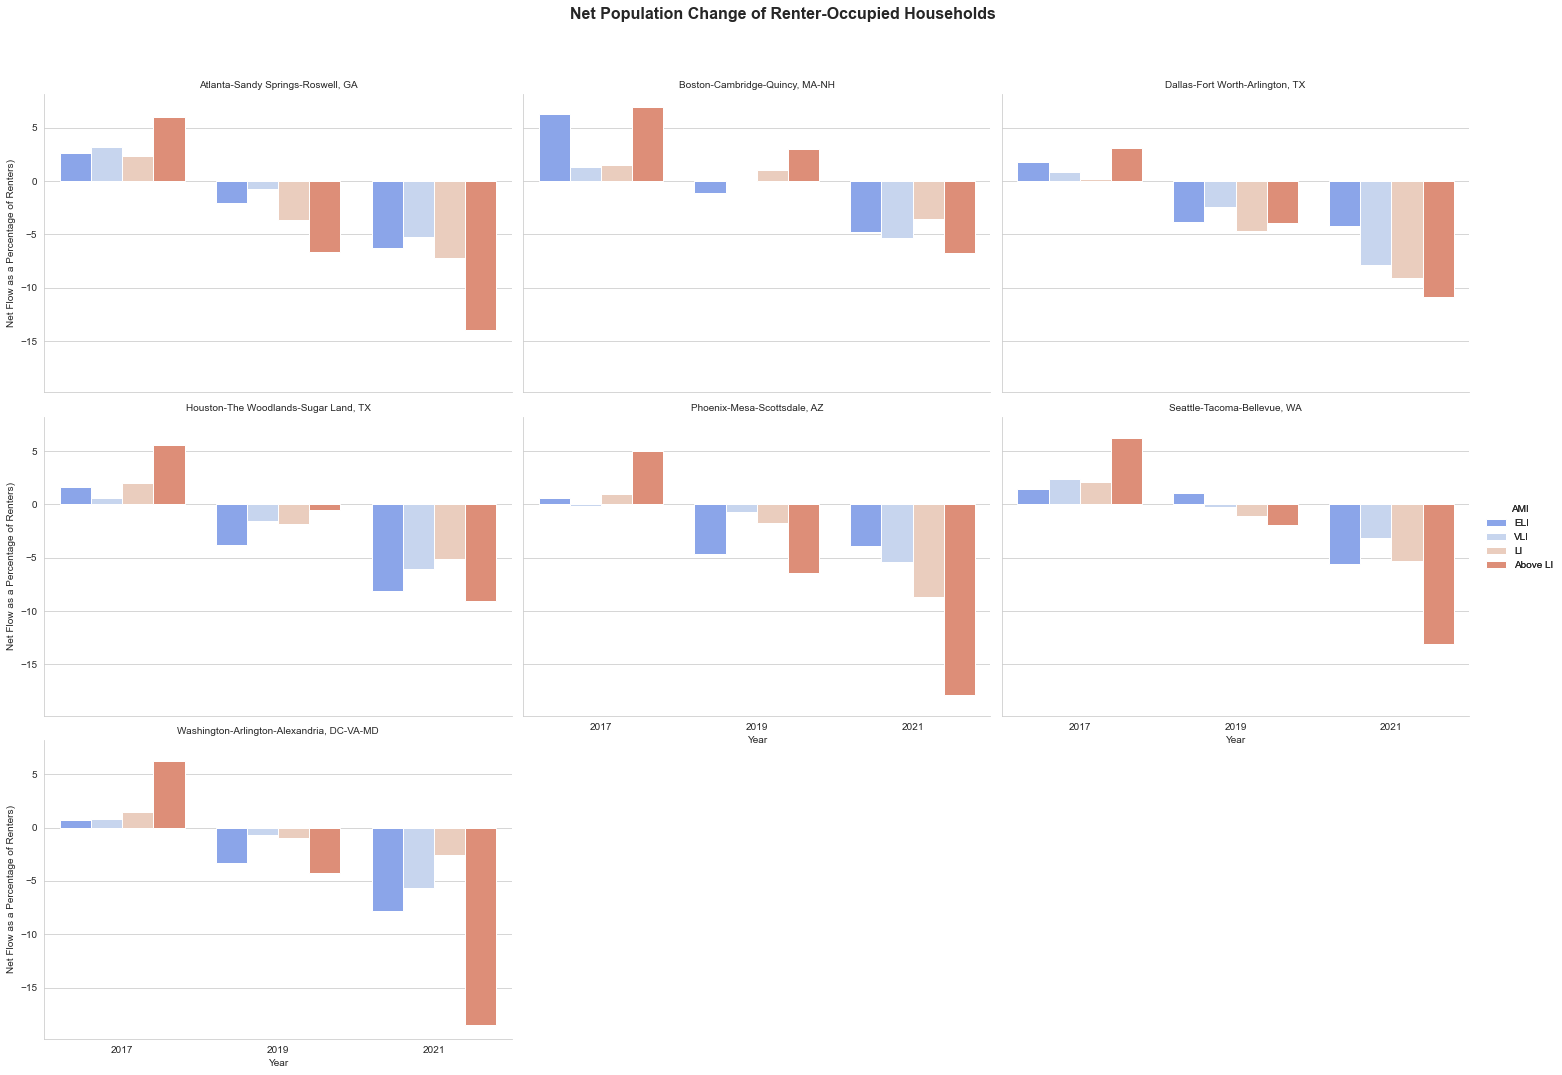

In [63]:
#Plot
sns.set_style("whitegrid")

g = sns.catplot(
    data=net_df_filtered,
    kind='bar',
    x='year',
    y='net_share',
    hue='AMI',
    col='Metro',
    palette='coolwarm',
    col_wrap=3,
    height=5,
    aspect=1.3,
    sharey=True
)

g.set_axis_labels("Year", "Net Flow as a Percentage of Renters)")
g.set_titles("{col_name}")
g.add_legend(title="AMI")
g.fig.suptitle("Net Population Change of Renter-Occupied Households", fontsize=16, fontweight='bold')
g.fig.subplots_adjust(top=0.9)

#Save and export image as png file
#g.savefig('net_pop_renter_change.png', dpi=300, bbox_inches='tight')

plt.show()

It appears that there are no values for net percentage change of VLI renters in the Boston Metro area. I am inspecting the `'net_flow'` variable to inspect if any issue is arising.

In [64]:
#Filter for VLI renters in Boston-Cambridge-Quincy metro
boston_vli_net = net_df[
    (net_df['Metro'] == 'Boston-Cambridge-Quincy, MA-NH') &
    (net_df['AMI'] == 'VLI')
].sort_values('year')

#Display the filtered results
print(boston_vli_net[['year', 'entries_weighted', 'exits_weighted', 'net_flow', 'total_renters_weighted', 'net_share']])

     year  entries_weighted  exits_weighted      net_flow  \
118  2015          0.000000     7997.895776  -7997.895776   
18   2017      25060.307003    16040.828446   9019.478556   
22   2019      16150.723691    15947.353008    203.370683   
26   2021      24403.371428    65847.453710 -41444.082282   
30   2023      17123.464666        0.000000  17123.464666   

     total_renters_weighted  net_share  
118           687055.499431  -1.164083  
18            694908.438709   1.297938  
22            730619.467829   0.027835  
26            774483.827471  -5.351188  
30            748236.565006   2.288509  


There was a 2 percent increase in the `'net_share'` of VLI renters in the Boston Metro Area. It may be too small of a percentage to appear on the plot.

### 3(b). Averaging Net Shares Over Time by Metro Area and AMI

In [65]:
#Filter for interior years only (excluding 2015 & 2023)
net_df_avg = net_df[(net_df['year'] > 2015) & (net_df['year'] < 2023)].copy()

In [66]:
#Compute average net share per Metro and AMI
avg_net = (
    net_df_avg.groupby(['Metro', 'AMI'], observed=True)[['net_flow', 'total_renters_weighted']]
    .sum().reset_index()
)
avg_net['avg_net_share'] = (avg_net['net_flow'] / avg_net['total_renters_weighted']) * 100

In [67]:
#Sort AMI for consistent bar order
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
avg_net['AMI'] = pd.Categorical(avg_net['AMI'], categories=ami_order, ordered=True)

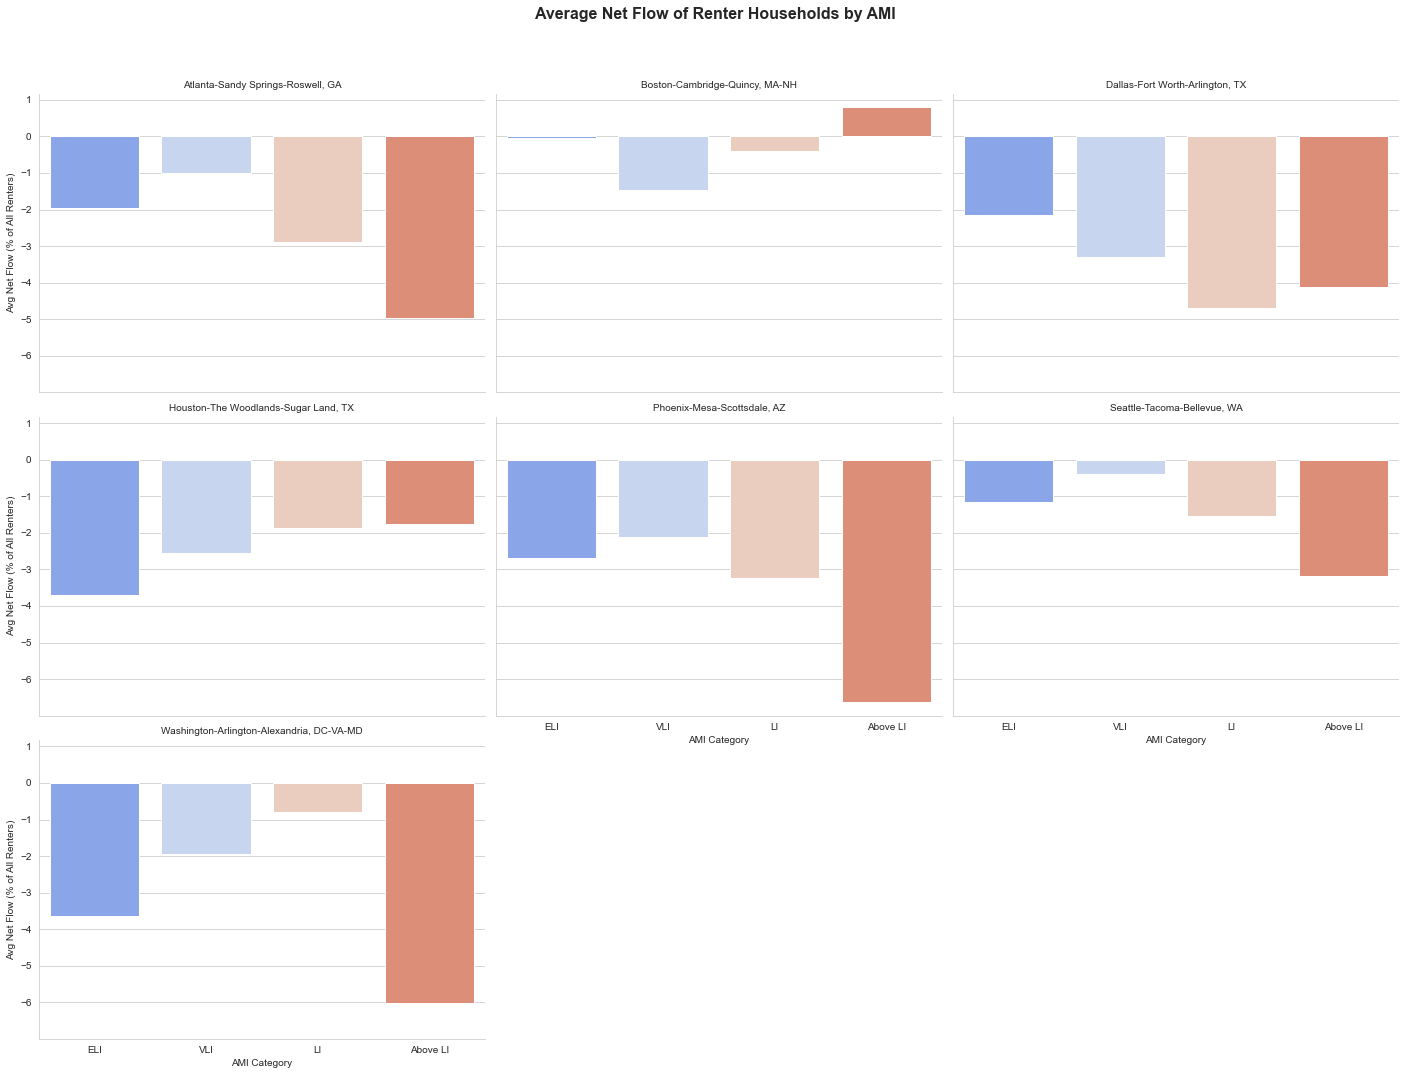

In [68]:
#Plot
sns.set_style("whitegrid")

g = sns.catplot(
    data=avg_net,
    kind='bar',
    x='AMI',
    y='avg_net_share',
    col='Metro',
    col_wrap=3,
    height=5,
    aspect=1.3,
    palette='coolwarm',
    sharey=True
)

g.set_axis_labels("AMI Category", "Avg Net Flow (% of All Renters)")
g.set_titles("{col_name}")
g.add_legend()
g.fig.suptitle("Average Net Flow of Renter Households by AMI", fontsize=16, fontweight='bold')
g.fig.subplots_adjust(top=0.9)

#Save and export image as png file
#g.savefig('avg_net_pop_renter_change.png', dpi=300, bbox_inches='tight')

plt.show()

### 3(c). Normalizing net migration flow by each AMI group's own population to examine how much each income group is growing or shrinking relative to its own size.

Steps:
- Compute total renters by Metro–Year–AMI.
- Merge that with net_df to get net_share_within_ami = net_flow / renters_in_same_ami_group.
- Filter out 2015 and 2023.
- Plot it like the original net_df_filtered, but with this new normalization.

In [69]:
#Total renters by Metro–Year–AMI (for within-group normalization)
total_ami_group_renters = (
    metro_rent_ami_df
    .assign(cbsa=lambda x: x['OMB13CBSA'].astype(str))
    .query("cbsa in @create_cbsa_name_mapping().keys()")
    .assign(Metro=lambda x: x['cbsa'].map(create_cbsa_name_mapping()))
    .groupby(['Metro', 'SRVYEAR', 'AMI'], observed=True)['WEIGHT']
    .sum()
    .reset_index()
    .rename(columns={'SRVYEAR': 'year', 'WEIGHT': 'renters_in_ami_group'})
)

In [70]:
#Merge with net_df
net_df_within = net_df.merge(
    total_ami_group_renters,
    on=['Metro', 'year', 'AMI'],
    how='left'
)

In [71]:
#Normalize net flow within AMI group
net_df_within['net_share_within_ami'] = (
    net_df_within['net_flow'] / net_df_within['renters_in_ami_group']
) * 100

In [72]:
#Filter out 2015 and 2023
net_df_within_filtered = net_df_within[
    (net_df_within['year'] > 2015) & (net_df_within['year'] < 2023)
].copy()

In [73]:
#Ensure AMI is ordered
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
net_df_within_filtered['AMI'] = pd.Categorical(
    net_df_within_filtered['AMI'], categories=ami_order, ordered=True
)

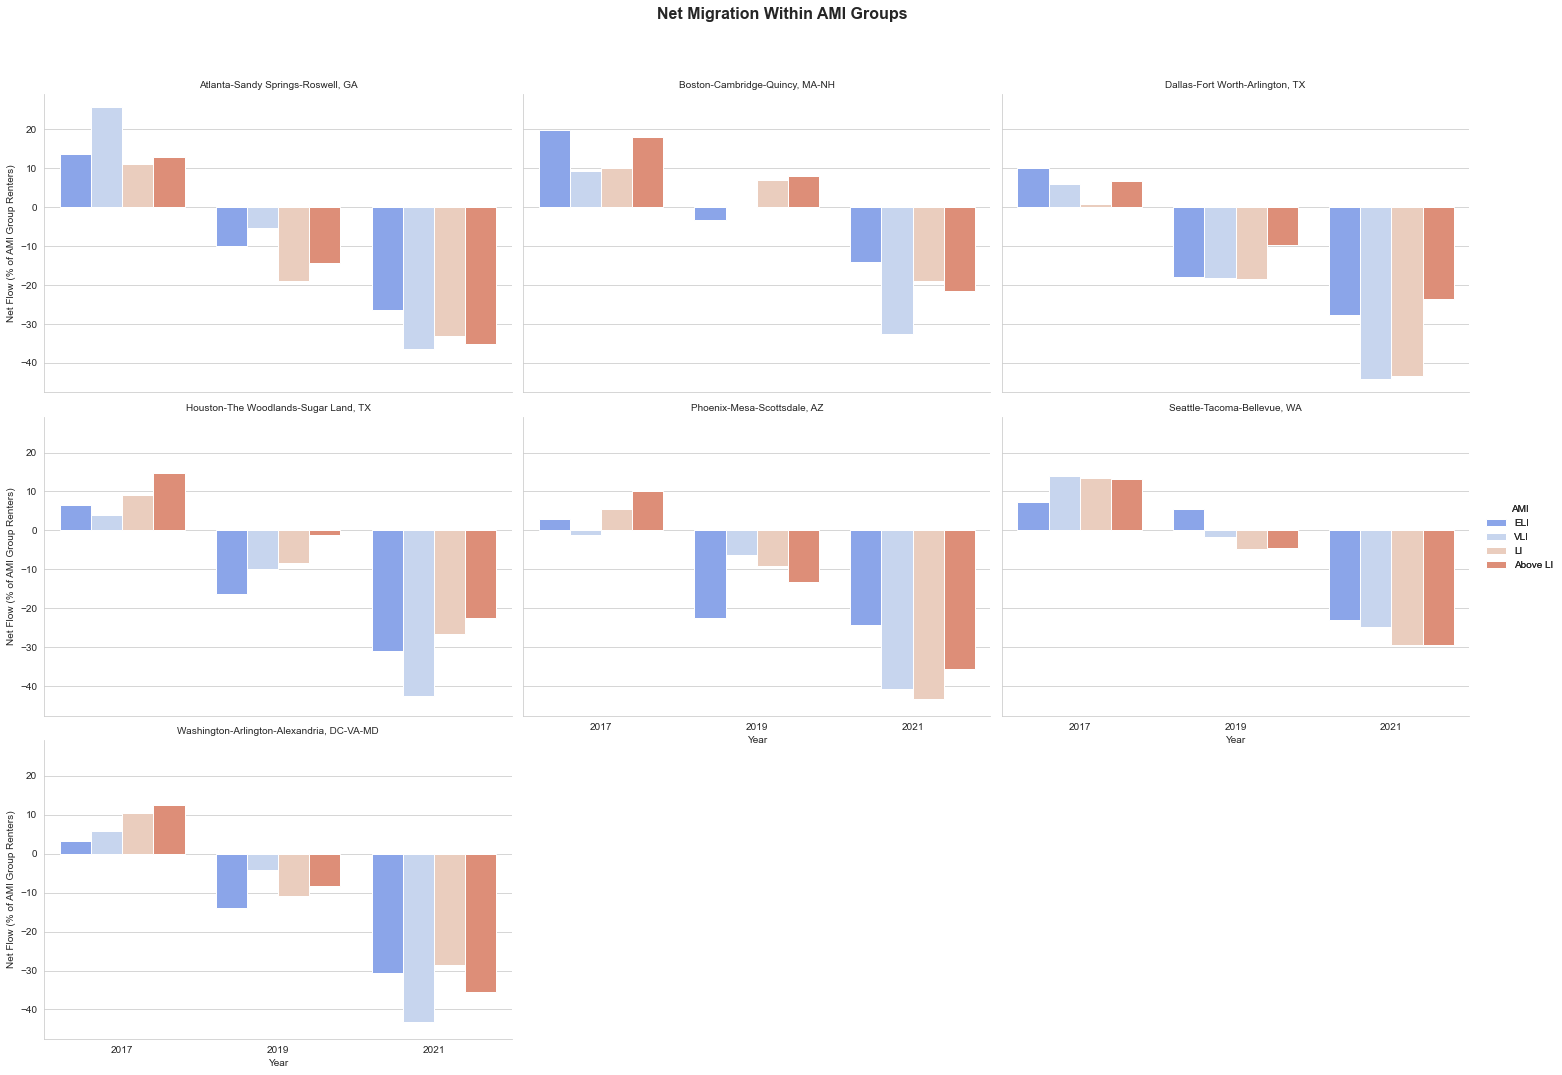

In [74]:
#Plot
sns.set_style("whitegrid")

g = sns.catplot(
    data=net_df_within_filtered,
    kind='bar',
    x='year',
    y='net_share_within_ami',
    hue='AMI',
    col='Metro',
    palette='coolwarm',
    col_wrap=3,
    height=5,
    aspect=1.3,
    sharey=True
)

g.set_axis_labels("Year", "Net Flow (% of AMI Group Renters)")
g.set_titles("{col_name}")
g.add_legend(title="AMI")
g.fig.suptitle("Net Migration Within AMI Groups", fontsize=16, fontweight='bold')
g.fig.subplots_adjust(top=0.9)

#Save and export image as png file
#g.savefig('net_migration_within_ami.png', dpi=300, bbox_inches='tight')

plt.show()

This plot answers:

“How much net flow (entries minus exits) happened relative to the size of each AMI group?”

This can help identify whether even small AMI groups are experiencing outsized change relative to their own size—even if their share of all renters is small.

## 4(a).  What share of all households exiting CBSAs each year cite housing costs as a reason?

The assumption is that the CBSA where renter households last appeared is the one they left, which is reasonable in the AHS panel since tracking destination cannot be done with the AHS. However, A household that disappears from a CBSA in a later year may have:
- Moved out of the CBSA,
- Or exited the survey entirely.

In [75]:
def calculate_cost_motivated_exit_share_by_ami(exits_with_info, create_cbsa_name_mapping):
    """
    Calculate the weighted share of households exiting each CBSA per year citing housing costs as a reason, disaggregated by AMI.
    """
    # Copy and prep
    df = exits_with_info.copy()
    df['RMCOSTS'] = df['RMCOSTS'].astype(str)

    # Filter valid RMCOSTS responses
    df = df[df['RMCOSTS'].isin(['1', '2'])]

    # Add Metro names
    cbsa_map = create_cbsa_name_mapping()
    df['Metro'] = df['last_cbsa'].astype(str).map(cbsa_map)

    # Drop rows missing Metro or AMI
    df = df.dropna(subset=['Metro', 'AMI'])

    # Create weighted cost flag
    df['weighted_cost'] = (df['RMCOSTS'] == '1').astype(int) * df['WEIGHT']

    # Group and aggregate
    grouped = (
        df.groupby(['Metro', 'exit_year', 'AMI'], observed=True)
          .agg(
              total_weighted_exits=('WEIGHT', 'sum'),
              cost_weighted_exits=('weighted_cost', 'sum')
          )
          .reset_index()
    )

    # Compute percent
    grouped['pct_cost_motivated'] = (grouped['cost_weighted_exits'] / grouped['total_weighted_exits']) * 100

    # Sort AMI
    ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
    grouped['AMI'] = pd.Categorical(grouped['AMI'], categories=ami_order, ordered=True)
    grouped['exit_year'] = grouped['exit_year'].astype(int)
    
    return grouped

In [76]:
def plot_cost_motivated_exit_share_by_ami(df): #, save_path=None):
    sns.set_style("whitegrid")
    
    g = sns.catplot(
        data=df,
        kind="bar",
        x="exit_year",
        y="pct_cost_motivated",
        hue="AMI",
        col="Metro",
        col_wrap=3,
        height=5,
        aspect=1.3,
        palette="Set2",
        sharey=True
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("Exit Year", "Percent Exits Due to Housing Costs")
    g.set(ylim=(0, 100))
    g.fig.suptitle("Share of Exiting Households Citing Housing Costs", fontsize=16, fontweight='bold')
    g.fig.subplots_adjust(top=0.9)
    
    # Save if path is given
#     if save_path:
#         g.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

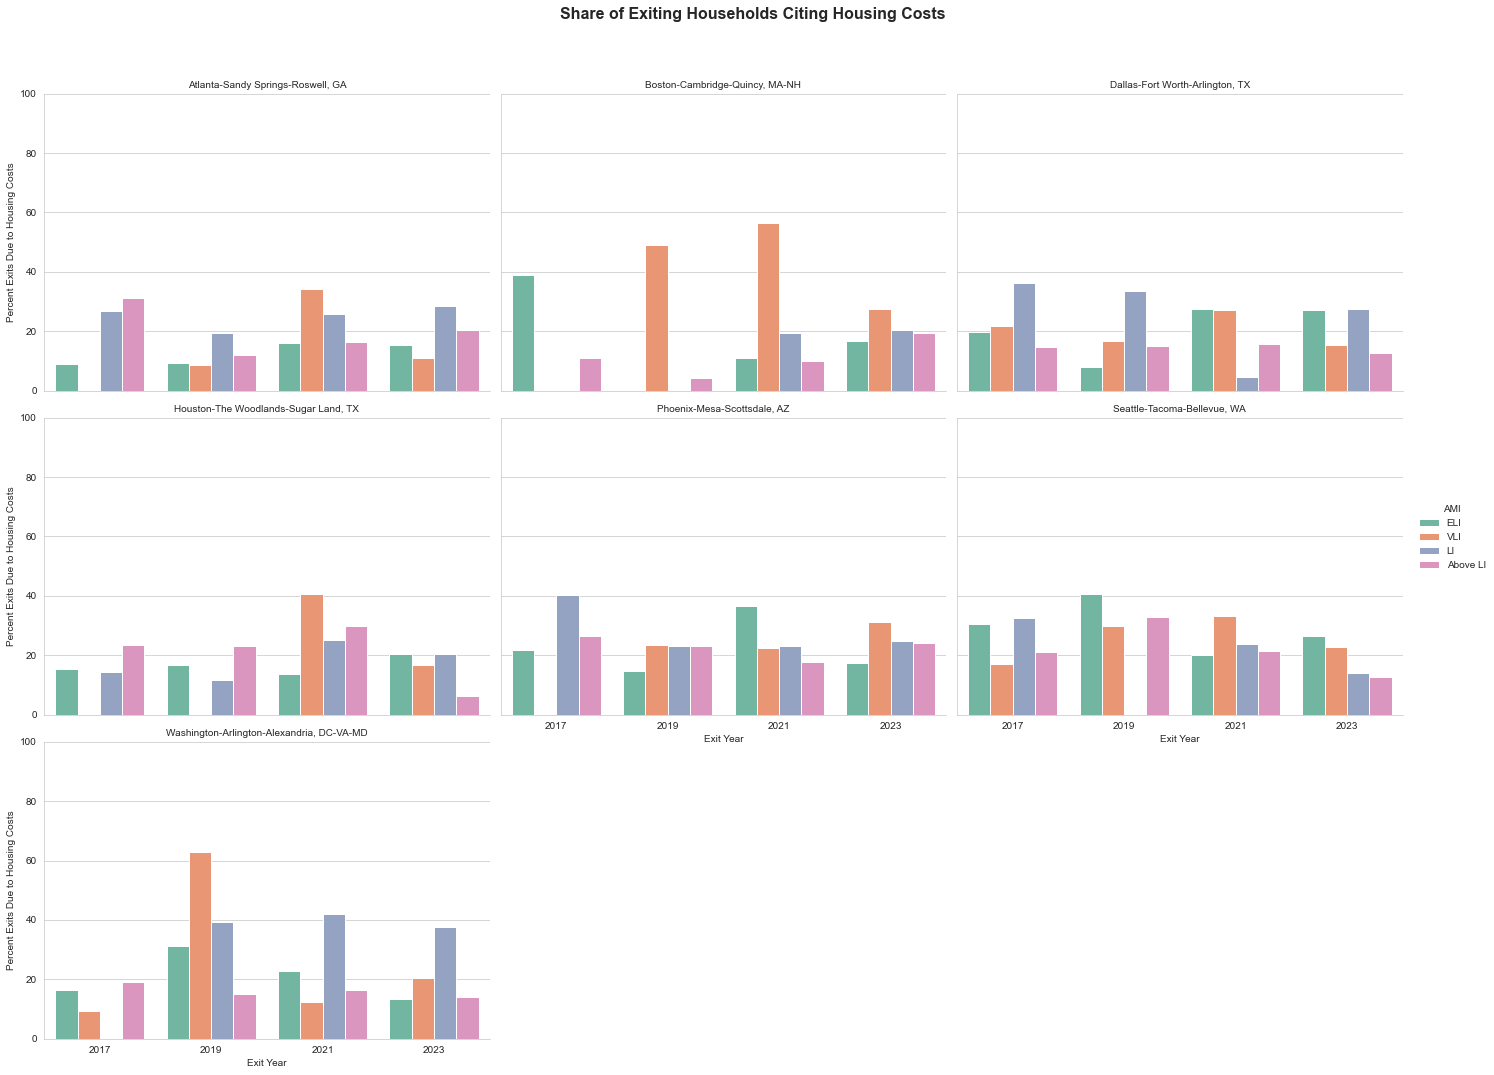

In [77]:
exits_df = find_household_exits(metro_rent_ami_df)
exits_with_info = add_housing_cost_info_exits(exits_df, metro_rent_ami_df)

cost_share_df = calculate_cost_motivated_exit_share_by_ami(exits_with_info, create_cbsa_name_mapping)
plot_cost_motivated_exit_share_by_ami(cost_share_df) #, save_path='share_housing_cost_exits.png')

In [78]:
#Verifying true zeros or missing data
#Check all combinations for Boston as an example
boston_check = cost_share_df.query("Metro == 'Boston-Cambridge-Quincy, MA-NH' and exit_year == 2019").copy()

# Show all AMI categories for completeness (even if missing)
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
boston_check['AMI'] = pd.Categorical(boston_check['AMI'], categories=ami_order, ordered=True)

#Reindex to show all AMI groups, even if missing
boston_check = (
    boston_check.set_index('AMI')
    .reindex(ami_order)
    .reset_index()
)

boston_check[['AMI', 'exit_year', 'total_weighted_exits', 'cost_weighted_exits', 'pct_cost_motivated']]

,AMI,exit_year,total_weighted_exits,cost_weighted_exits,pct_cost_motivated
0,ELI,2019,7251.708522,0.000000,0.000000
1,VLI,2019,4080.185837,2003.257859,49.097221
2,LI,2019,12820.214876,0.000000,0.000000
3,Above LI,2019,20780.861738,911.180775,4.384711


### 4(b) Among 2015 renters, who exited and cited high housing costs?

In [79]:
def find_2015_renter_exits(df):
    """
    Identify households who lived in a CBSA in 2015 and exited before 2023.
    """
    base_2015 = df[df['SRVYEAR'] == 2015]
    control_ids_2015 = base_2015['CONTROL'].unique()

    # Subset panel to 2015 renters
    renters_2015_panel = df[df['CONTROL'].isin(control_ids_2015)].copy()

    # Use existing logic
    exits_df = find_household_exits(renters_2015_panel)
    
    return exits_df

In [80]:
def add_cost_info_to_2015_exits(exits_df, original_df):
    """
    Add RMCOSTS, WEIGHT, and AMI from last observation before exit.
    """
    return add_housing_cost_info_exits(exits_df, original_df)

In [81]:
def calculate_cost_motivated_share_among_2015_renters(exits_with_info):
    df = exits_with_info.copy()
    df['RMCOSTS'] = df['RMCOSTS'].astype(str)

    df = df[df['RMCOSTS'].isin(['1', '2'])]
    df['cost_flag'] = (df['RMCOSTS'] == '1').astype(int)
    df['weighted_flag'] = df['cost_flag'] * df['WEIGHT']

    grouped = (
        df.groupby(['exit_year', 'last_cbsa', 'AMI'], observed=True)
        .agg(
            total_exits_weighted=('WEIGHT', 'sum'),
            cost_exits_weighted=('weighted_flag', 'sum'),
            sample_size=('CONTROL', 'count')
        )
        .reset_index()
    )

    grouped['pct_cost_motivated'] = (
        100 * grouped['cost_exits_weighted'] / grouped['total_exits_weighted']
    ).fillna(0)

    return grouped

In [82]:
#Clean for plotting
def format_2015_exit_cost_plot_table(df):
    cbsa_map = create_cbsa_name_mapping()
    df = df.copy()
    df['last_cbsa'] = df['last_cbsa'].astype(str)
    df = df[df['last_cbsa'].isin(cbsa_map.keys())]
    df['Metro'] = df['last_cbsa'].map(cbsa_map)
    df['AMI'] = pd.Categorical(df['AMI'], categories=['ELI', 'VLI', 'LI', 'Above LI'], ordered=True)
    df['exit_year'] = df['exit_year'].astype(int)
    return df.sort_values(['Metro', 'exit_year', 'AMI'])

In [83]:
def plot_cost_motivated_2015_exits(df): #, save_path=None):
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=df,
        kind='bar',
        x='exit_year',
        y='pct_cost_motivated',
        hue='AMI',
        col='Metro',
        col_wrap=3,
        palette='Set2',
        height=5,
        aspect=1.3,
        sharey=True
    )

    g.set_axis_labels("Exit Year", "Percent of Exits Due to Housing Costs")
    g.set_titles("{col_name}")
    g.set(ylim=(0, 100))
    g.add_legend(title="AMI")
    g.fig.suptitle("Cost-Motivated Exits Among Renter Households Living in a Metropolitan Area Since 2015", fontsize=16, fontweight='bold')
    g.fig.subplots_adjust(top=0.9)
    
    # Save if path is given
#     if save_path:
#         g.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

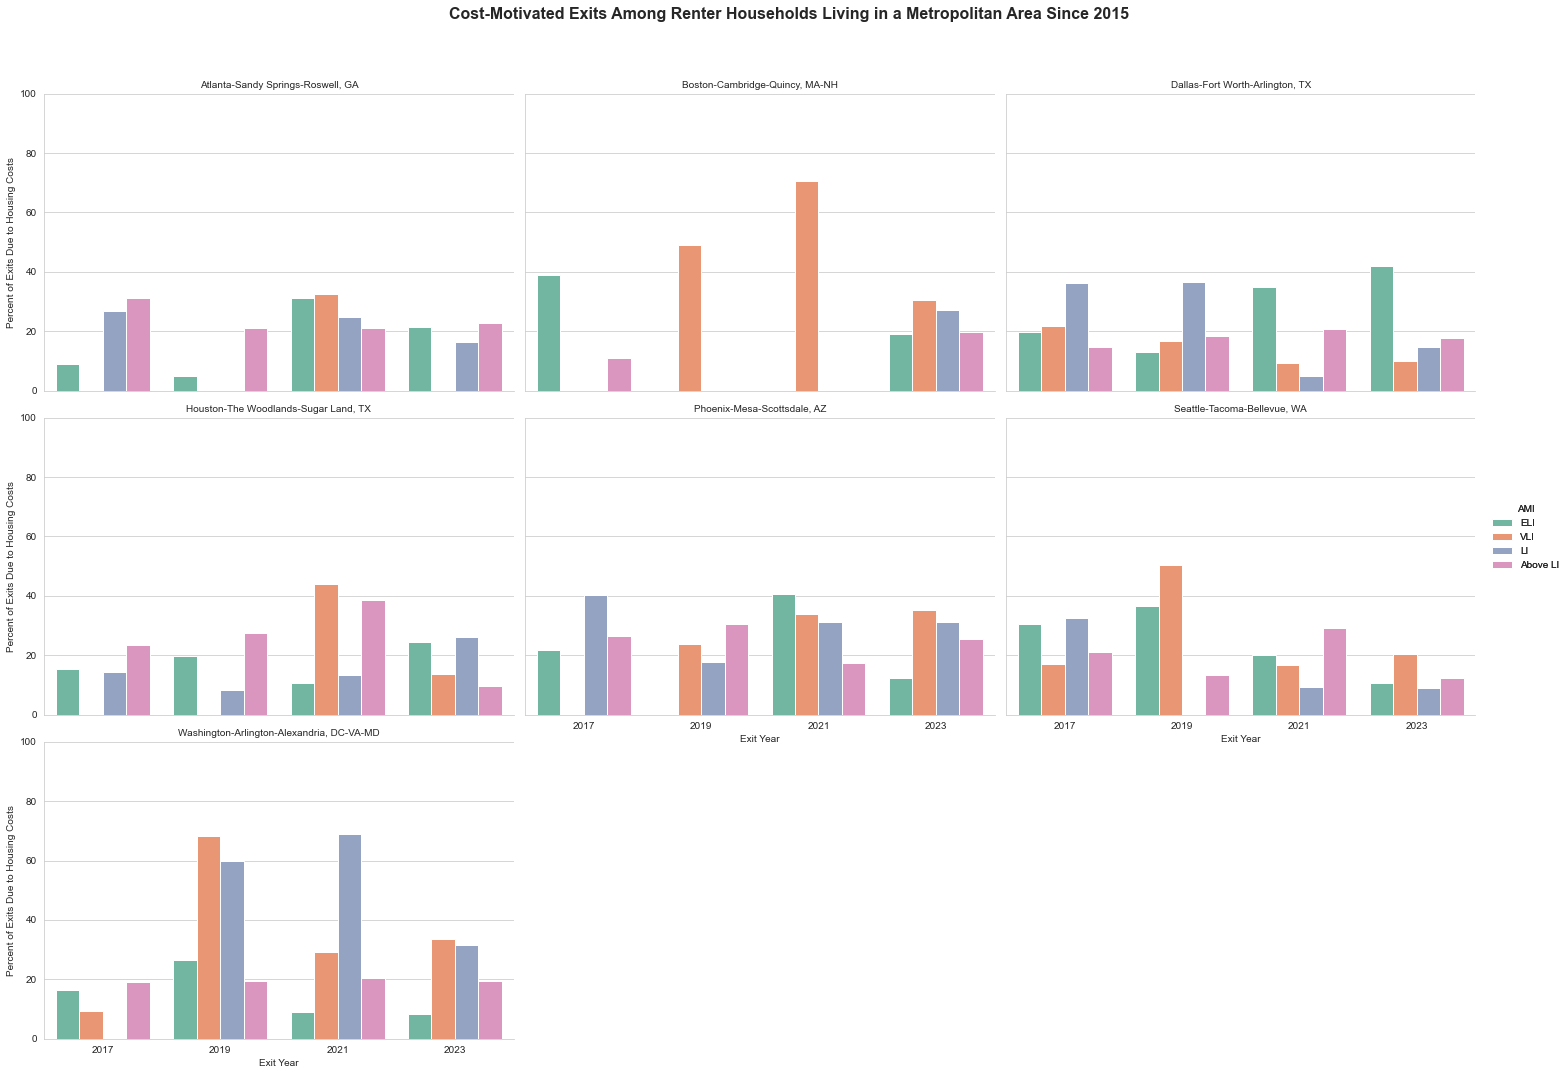

In [84]:
#Usage Pipeline
exits_2015 = find_2015_renter_exits(metro_rent_ami_df)
exits_with_info = add_cost_info_to_2015_exits(exits_2015, metro_rent_ami_df)
summary_2015 = calculate_cost_motivated_share_among_2015_renters(exits_with_info)
final_2015_table = format_2015_exit_cost_plot_table(summary_2015)
plot_cost_motivated_2015_exits(final_2015_table) #, save_path='housing_cost_exits_2015.png')

In [85]:
#Verifying true zeros or missing data
#Check for Boston as an example
metro_to_check = "Boston-Cambridge-Quincy, MA-NH"
year_to_check = 2019

subset = final_2015_table.query("Metro == @metro_to_check and exit_year == @year_to_check").copy()

In [86]:
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
subset['AMI'] = pd.Categorical(subset['AMI'], categories=ami_order, ordered=True)

In [87]:
#Reindex so that all AMI groups appear, even if missing
subset = (
    subset.set_index('AMI')
    .reindex(ami_order)
    .reset_index()
)

In [88]:
subset[['AMI', 'exit_year', 'total_exits_weighted', 'cost_exits_weighted', 'pct_cost_motivated']]

,AMI,exit_year,total_exits_weighted,cost_exits_weighted,pct_cost_motivated
0,ELI,2019,3831.556868,0.000000,0.000000
1,VLI,2019,4080.185837,2003.257859,49.097221
2,LI,2019,1336.297888,0.000000,0.000000
3,Above LI,2019,7912.196042,0.000000,0.000000


There were exits from Boston Metro Area in 2019, just not for housing costs reasons.

### 4(c). Are certain AMI groups leaving  CBSAs at a higher rate because of housing costs?
#### Among all households in a given CBSA and AMI group in a given year, what share exited the CBSA by the next survey wave because of housing costs?

In [89]:
#Summarize cost-motivated extis only

def summarize_cost_motivated_exits(df_exits, cbsa_map):
    df = df_exits.copy()

    #Clean & filter for valid responses
    df['RMCOSTS'] = df['RMCOSTS'].astype(str)
    df = df[df['RMCOSTS'] == '1']  # only cost-motivated exits

    #Clean metro names
    df['last_cbsa'] = df['last_cbsa'].astype(str)
    df['Metro'] = df['last_cbsa'].map(cbsa_map)
    df = df.dropna(subset=['Metro', 'AMI'])
    df = df[df['AMI'].isin(['ELI', 'VLI', 'LI', 'Above LI'])].copy()

    #Group by Metro, Exit Year, and AMI
    exits_grouped = (
        df.groupby(['Metro', 'exit_year', 'AMI'], observed=True)
        .agg(weighted_cost_exits=('WEIGHT', 'sum'))
        .reset_index()
    )

    return exits_grouped

In [90]:
#Summarize renter base in the year before household exit
def summarize_weighted_renters(original_df, cbsa_map):
    df = original_df.copy()
    df['OMB13CBSA'] = df['OMB13CBSA'].astype(str)
    df['Metro'] = df['OMB13CBSA'].map(cbsa_map)

    df = df.dropna(subset=['Metro', 'AMI'])
    df = df[df['AMI'].isin(['ELI', 'VLI', 'LI', 'Above LI'])].copy()

    renters_grouped = (
        df.groupby(['Metro', 'SRVYEAR', 'AMI'], observed=True)
        .agg(weighted_renters=('WEIGHT', 'sum'))
        .reset_index()
        .rename(columns={'SRVYEAR': 'entry_year'})
    )

    return renters_grouped

In [91]:
#Merge and calculate cost-motivated exit rate
def calculate_cost_motivated_exit_rate(exits_grouped, renters_grouped):
    
    #Align renter counts from the prior wave
    renters_grouped['exit_year'] = renters_grouped['entry_year'] + 2 #The 2-year shift reflects AHS’s biannual design (e.g., 2015 renters → 2017 exits).

    merged = exits_grouped.merge(
        renters_grouped.drop(columns='entry_year'),
        on=['Metro', 'exit_year', 'AMI'],
        how='left'
    )

    merged['exit_rate_due_to_costs'] = (
        merged['weighted_cost_exits'] / merged['weighted_renters']
    ) * 100

    merged['AMI'] = pd.Categorical(merged['AMI'], categories=['ELI', 'VLI', 'LI', 'Above LI'], ordered=True)
    merged['exit_year'] = merged['exit_year'].astype(int)

    return merged

In [92]:
#Master function to execute code/function sequence
def calculate_cost_motivated_exit_rates_by_ami_year_cbsa(exits_with_info, original_df, create_cbsa_name_mapping):
    cbsa_map = create_cbsa_name_mapping()
    exits_grouped = summarize_cost_motivated_exits(exits_with_info, cbsa_map)
    renters_grouped = summarize_weighted_renters(original_df, cbsa_map)
    return calculate_cost_motivated_exit_rate(exits_grouped, renters_grouped)

In [93]:
#Usage
exits_df = find_household_exits(metro_rent_ami_df)
exits_with_info = add_housing_cost_info_exits(exits_df, metro_rent_ami_df)

cost_exit_rates = calculate_cost_motivated_exit_rates_by_ami_year_cbsa(
    exits_with_info,
    metro_rent_ami_df,
    create_cbsa_name_mapping
)

In [94]:
#Plot

def plot_cost_motivated_exit_rates(df): #, save_path=None):
    """
    Plot % of renters who exited their CBSA due to housing costs,
    disaggregated by Metro, Year, and AMI Category.

    Parameters:
        df: DataFrame with columns ['Metro', 'exit_year', 'AMI', 'exit_rate_due_to_costs']
    """

    # Ensure clean ordering
    sns.set_style("whitegrid")
    df = df.copy()
    df['AMI'] = pd.Categorical(df['AMI'], categories=['ELI', 'VLI', 'LI', 'Above LI'], ordered=True)
    df['exit_year'] = df['exit_year'].astype(int)

    # Set up FacetGrid plot
    g = sns.catplot(
        data=df,
        kind='bar',
        x='exit_year',
        y='exit_rate_due_to_costs',
        hue='AMI',
        col='Metro',
        col_wrap=3,
        palette='Set2',
        height=5,
        aspect=1.3,
        sharey=True
    )

    g.set_axis_labels("Exit Year", "Percent of Renters Who Exited Due to Housing Costs")
    g.set_titles("{col_name}")
    g.set(ylim=(0, df['exit_rate_due_to_costs'].max() * 1.1))
    g.add_legend(title="AMI")

    # Main title
    g.fig.suptitle("Cost-Motivated Exit Rates by AMI", fontsize=16, fontweight='bold')
    g.fig.subplots_adjust(top=0.9)
    
    # Save if path is given
#     if save_path:
#         g.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

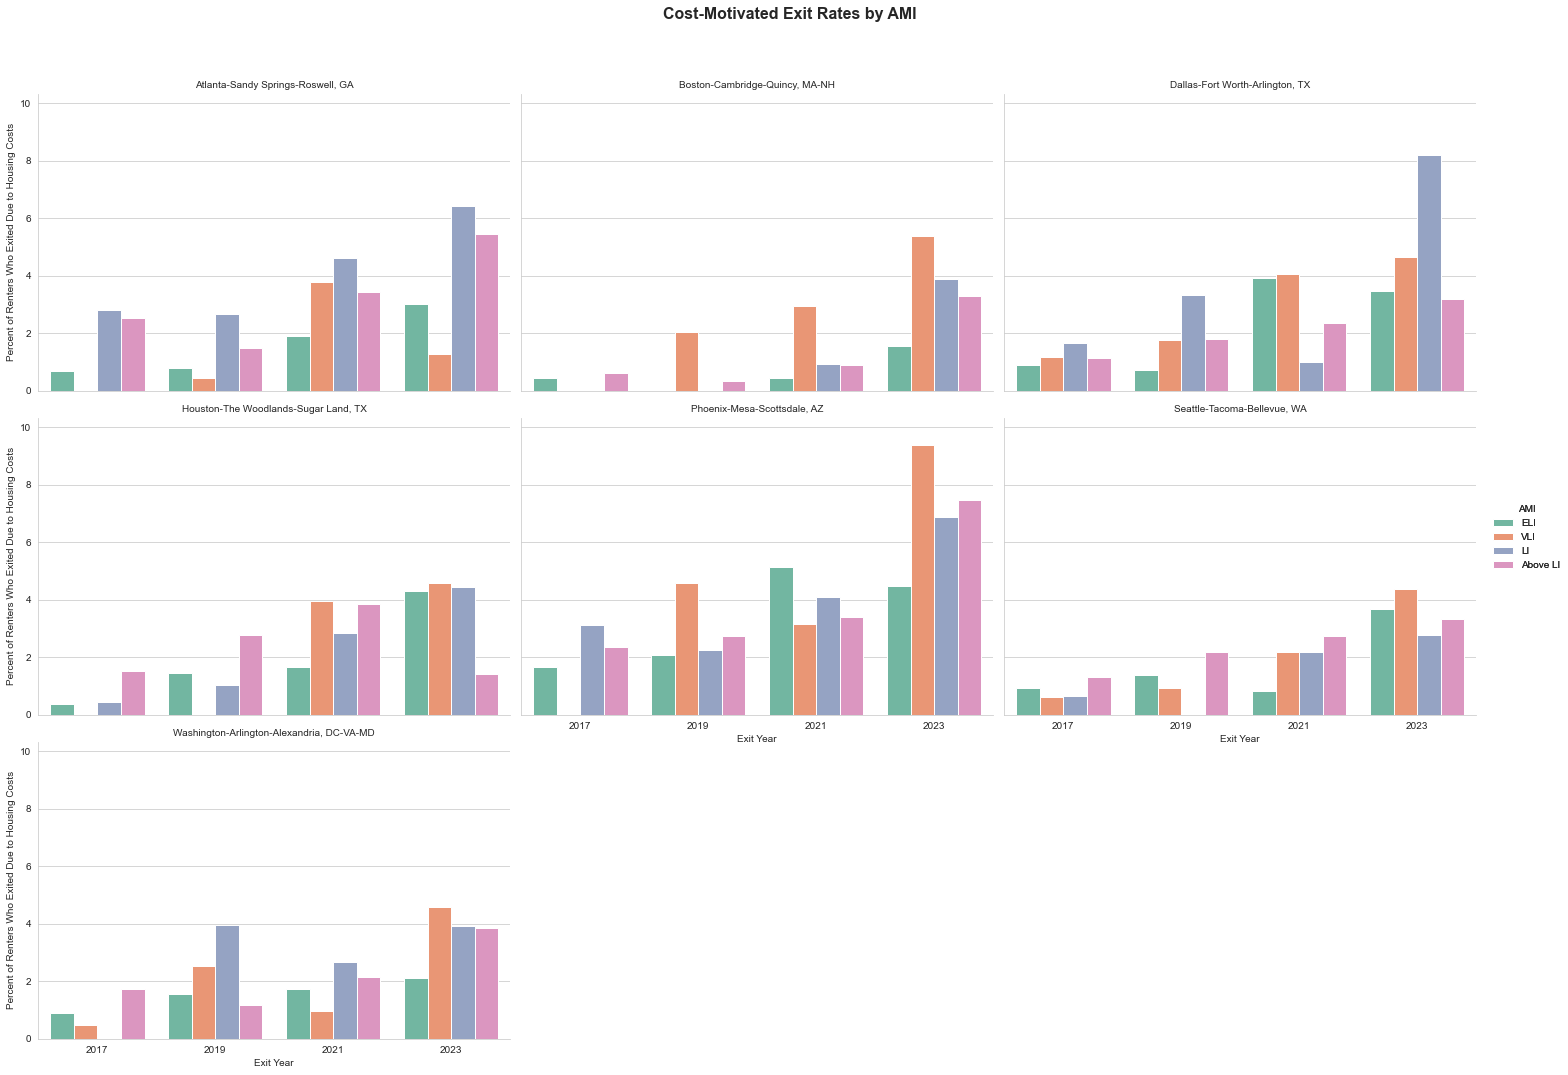

In [95]:
plot_cost_motivated_exit_rates(cost_exit_rates) #, save_path='cost_exit_rate.png')

## 5(a). What about the inverse? What share of all renter households that are moving into CBSAs each year cite housing costs as a reason? 

In [96]:
#Clean and filter valid entires
def clean_entries_data(entries_df):
    """
    Keep only valid RMCOSTS values (1 = yes, 2 = no), convert types, and flag housing-cost entries.
    """
    df = entries_df.copy()
    df['RMCOSTS'] = df['RMCOSTS'].astype(str)
    df = df[df['RMCOSTS'].isin(['1', '2'])]

    df['cost_reduction_flag'] = (df['RMCOSTS'] == '1').astype(int)
    df['weighted_cost_reduction'] = df['cost_reduction_flag'] * df['WEIGHT']
    
    return df

In [97]:
#Aggregate entries by year, CBSA, and AMI
def summarize_cost_motivated_entries(clean_df):
    """
    Group cleaned entry data and calculate totals and percentages.
    """
    grouped = (
        clean_df.groupby(['first_year_present', 'entry_cbsa', 'AMI'], observed=True)
        .agg(
            total_entries_weighted=('WEIGHT', 'sum'),
            cost_reduction_entries_weighted=('weighted_cost_reduction', 'sum'),
            n_households=('CONTROL', 'count')
        )
        .reset_index()
        .rename(columns={'first_year_present': 'entry_year', 'entry_cbsa': 'cbsa'})
    )

    grouped['pct_cost_reduction_entries'] = np.where(
        grouped['total_entries_weighted'] > 0,
        100 * grouped['cost_reduction_entries_weighted'] / grouped['total_entries_weighted'],
        0
    )

    return grouped

In [98]:
#Format for display/plotting
def format_entry_summary_for_plotting(summary_df):
    """
    Add Metro names, format AMI categories, and sort for display.
    """
    cbsa_map = create_cbsa_name_mapping()
    df = summary_df.copy()
    df['cbsa'] = df['cbsa'].astype(str)
    df = df[df['cbsa'].isin(cbsa_map.keys())]

    df['Metro'] = df['cbsa'].map(cbsa_map)
    df['AMI'] = pd.Categorical(df['AMI'], categories=['ELI', 'VLI', 'LI', 'Above LI'], ordered=True)
    df['entry_year'] = df['entry_year'].astype(int)

    return df.sort_values(['Metro', 'entry_year', 'AMI'])

In [99]:
#Plot
def plot_cost_motivated_entries(df): #, save_path=None):
    """
    Plot % of renter entries citing housing costs by metro, year, and AMI.
    """
    sns.set_style("whitegrid")
    
    g = sns.catplot(
        data=df,
        kind='bar',
        x='entry_year',
        y='pct_cost_reduction_entries',
        hue='AMI',
        col='Metro',
        col_wrap=3,
        palette='Set2',
        height=5,
        aspect=1.3,
        sharey=True
    )

    g.set_axis_labels("Entry Year", "Percent Entered Metro to Reduce Housing Costs")
    g.set_titles("{col_name}")
    g.set(ylim=(0, 100))
    g.add_legend(title="AMI")
    g.fig.suptitle("Cost-Motivated Renter Migration into Metropolitan Areas", fontsize=16, fontweight='bold')
    g.fig.subplots_adjust(top=0.9)
    
    # Save if path is given
#     if save_path:
#         g.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

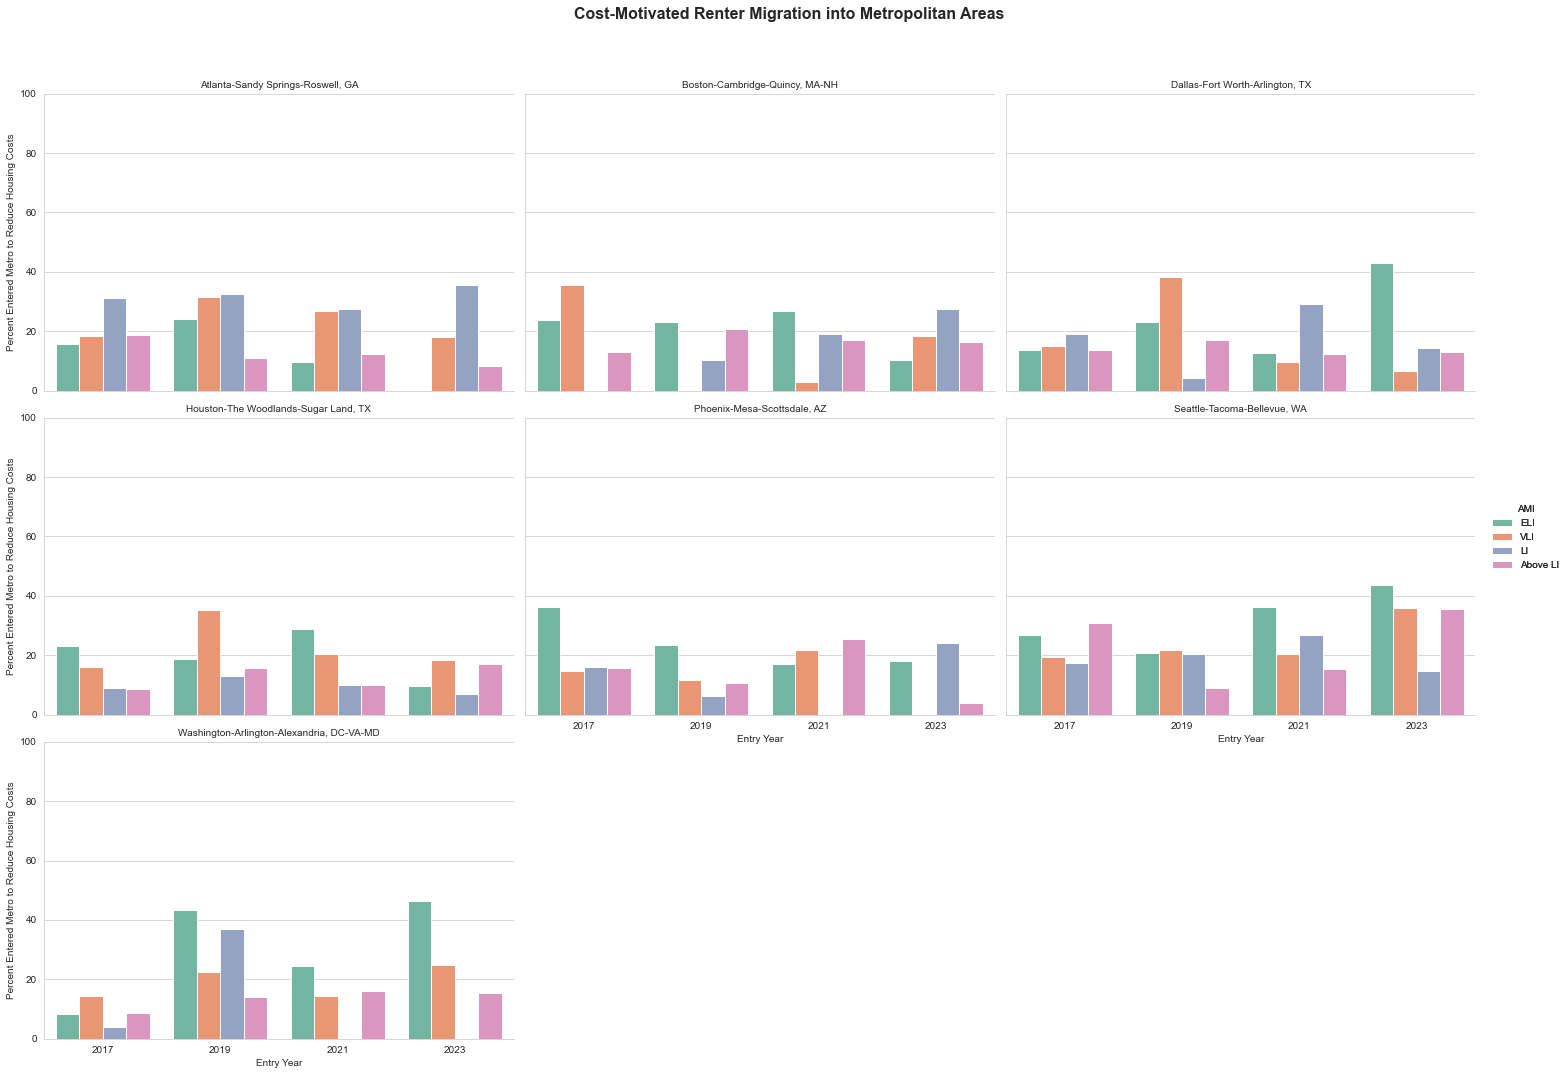

In [100]:
#Usage
entries_df = find_household_entries(metro_rent_ami_df)
entries_with_info = add_housing_cost_info_entries(entries_df, metro_rent_ami_df)

clean_entries = clean_entries_data(entries_with_info)
entry_summary = summarize_cost_motivated_entries(clean_entries)
formatted_entry_table = format_entry_summary_for_plotting(entry_summary)

plot_cost_motivated_entries(formatted_entry_table) #, save_path='cost_entries_into_metro.png')

In [101]:
#check: viewing a specific metro/year
formatted_entry_table.query("Metro == 'Boston-Cambridge-Quincy, MA-NH' and entry_year == 2019")

,entry_year,cbsa,AMI,total_entries_weighted,cost_reduction_entries_weighted,n_households,pct_cost_reduction_entries,Metro
35,2019,14460,ELI,8909.404673,2065.514095,7,23.183525,"Boston-Cambridge-Quincy, MA-NH"
34,2019,14460,VLI,9971.507381,0.000000,8,0.000000,"Boston-Cambridge-Quincy, MA-NH"
33,2019,14460,LI,9900.745215,1024.402607,8,10.346722,"Boston-Cambridge-Quincy, MA-NH"
32,2019,14460,Above LI,53577.172096,11053.206624,41,20.630441,"Boston-Cambridge-Quincy, MA-NH"


No VLI movers into Boston Metro Area in 2019

### 5(b). Are certain AMI groups moving _into_ a CBSA at a higher rate for housing affordability?

In [102]:
#Clean and filter entry data
def prepare_clean_entries_for_rate_calc(entries_with_info):
    """
    Filter to valid RMCOSTS responses and prepare entry data for rate calculation.
    """
    df = entries_with_info.copy()
    df['RMCOSTS'] = df['RMCOSTS'].astype(str)
    df = df[df['RMCOSTS'].isin(['1', '2'])]

    df['cost_flag'] = (df['RMCOSTS'] == '1').astype(int)
    df['weighted_flag'] = df['cost_flag'] * df['WEIGHT']
    df['entry_cbsa'] = df['entry_cbsa'].astype(str)

    return df

In [103]:
#Summarize cost-motivated entries
def group_cost_entries_by_year_metro_ami(df):
    """
    Group and sum entries by entry year, CBSA, and AMI.
    """
    grouped = (
        df.groupby(['entry_cbsa', 'first_year_present', 'AMI'], observed=True)
        .agg(
            weighted_entries=('WEIGHT', 'sum'),
            cost_entries_weighted=('weighted_flag', 'sum'),
            sample_size=('CONTROL', 'count')
        )
        .reset_index()
        .rename(columns={'first_year_present': 'entry_year', 'entry_cbsa': 'cbsa'})
    )

    return grouped

In [104]:
#Calculate toal renter population (Denominator)
def calculate_total_renters(original_df):
    """
    Total weighted renters per Metro–Year–AMI (denominator for entry rates).
    """
    cbsa_map = create_cbsa_name_mapping()
    renters = original_df.copy()
    renters['cbsa'] = renters['OMB13CBSA'].astype(str)
    renters['Metro'] = renters['cbsa'].map(cbsa_map)

    renters = renters.dropna(subset=['Metro', 'AMI'])
    renters = renters[renters['AMI'].isin(['ELI', 'VLI', 'LI', 'Above LI'])].copy()

    renters_grouped = (
        renters.groupby(['Metro', 'SRVYEAR', 'AMI'], observed=True)
        .agg(weighted_renters=('WEIGHT', 'sum'))
        .reset_index()
        .rename(columns={'SRVYEAR': 'entry_year'})
    )

    return renters_grouped

In [105]:
#Merge numerator and demoninator
def merge_and_calculate_entry_rate(entry_grouped, renter_totals):
    """
    Merge entries and renter population to compute entry rates.
    """
    cbsa_map = create_cbsa_name_mapping()
    entry_grouped['Metro'] = entry_grouped['cbsa'].map(cbsa_map)
    
    entry_grouped = entry_grouped.dropna(subset=['Metro', 'AMI'])
    entry_grouped = entry_grouped[entry_grouped['AMI'].isin(['ELI', 'VLI', 'LI', 'Above LI'])].copy()

    merged = entry_grouped.merge(
        renter_totals,
        on=['Metro', 'entry_year', 'AMI'],
        how='left'
    )

    merged['entry_rate'] = (merged['weighted_entries'] / merged['weighted_renters']) * 100

    ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
    merged['AMI'] = pd.Categorical(merged['AMI'], categories=ami_order, ordered=True)
    merged['entry_year'] = merged['entry_year'].astype(int)

    return merged

In [106]:
#plot
def plot_entry_rates_by_ami(merged_df): #, save_path=None):
    """
    Faceted bar plot of entry rates by Metro, Year, and AMI.
    """
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=merged_df,
        kind='bar',
        x='entry_year',
        y='entry_rate',
        hue='AMI',
        col='Metro',
        col_wrap=3,
        palette='Set2',
        height=5,
        aspect=1.3,
        sharey=True
    )

    g.set_axis_labels("Entry Year", "Entry Rate (Percent of All Renters in Year)")
    g.set_titles("{col_name}")
    g.set(ylim=(0, merged_df['entry_rate'].max() * 1.1))
    g.add_legend(title="AMI")
    g.fig.suptitle("Renter Entry Rates by AMI", fontsize=16, fontweight='bold')
    g.fig.subplots_adjust(top=0.9)
    
    # Save if path is given
#     if save_path:
#         g.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

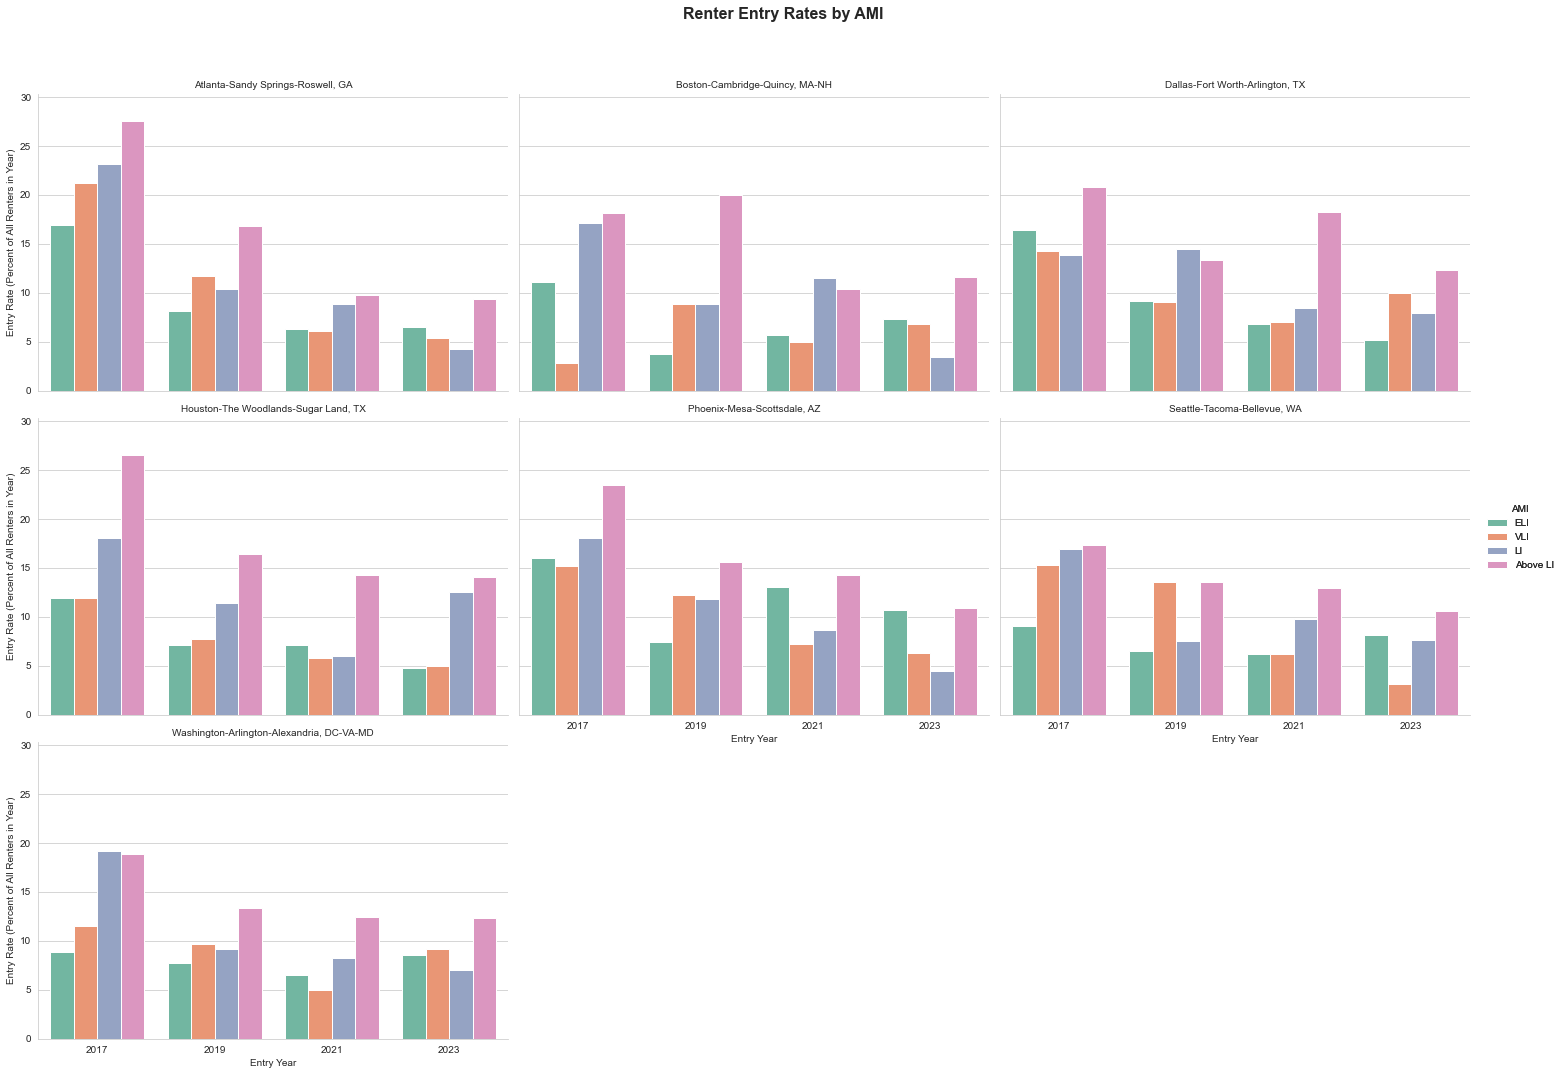

In [107]:
#Usage

# Load + process data
entries_df = find_household_entries(metro_rent_ami_df)
entries_with_info = add_housing_cost_info_entries(entries_df, metro_rent_ami_df)

# Calculate numerator
cleaned_entries = prepare_clean_entries_for_rate_calc(entries_with_info)
entry_grouped = group_cost_entries_by_year_metro_ami(cleaned_entries)

# Calculate denominator
renter_totals = calculate_total_renters(metro_rent_ami_df)

# Merge + calculate rates
entry_rate_table = merge_and_calculate_entry_rate(entry_grouped, renter_totals)

# Plot
plot_entry_rates_by_ami(entry_rate_table) #, save_path='renter_entry_rate.png')

## 6(a). Changes in rent for renter-occupied households of market-rate units (i.e., unsubsidized, not income-restricted housing)
- How have rents changed for lower income households (<= 80% AMI) in relation to higher income households (>80 AMI)? 
- What is the percent change of rent for households in each income group over time (2015-2023)?
- Are rent increases higher for ELI, LI, or LI renters than for higher-income renters?

In [108]:
#Filter to unassisted renter households in market-rate units
unassisted_df = metro_rent_ami_df.loc[
    (metro_rent_ami_df['HUDSUB'] == '3') &
    (metro_rent_ami_df['RENTSUB'] == '8'),
    ['OMB13CBSA', 'SRVYEAR', 'RENT', 'AMI', 'WEIGHT']
].copy()

Dropping `'RENTCNTRL'` becuase Washington DC metro area is the only CBSA that valid responses

In [109]:
#Map CBSA codes to metro names
unassisted_df['OMB13CBSA'] = unassisted_df['OMB13CBSA'].astype(str)
unassisted_df['Metro'] = unassisted_df['OMB13CBSA'].map(create_cbsa_name_mapping())
unassisted_df = unassisted_df.dropna(subset=['Metro'])

In [110]:
#Compute weighted rent components
unassisted_df['rent_x_weight'] = unassisted_df['RENT'] * unassisted_df['WEIGHT']

In [111]:
#Aggregate by Metro, AMI, SRVYEAR
agg = (
    unassisted_df
    .groupby(['Metro', 'AMI', 'SRVYEAR'], as_index=False)
    .agg(
        weighted_rent_num=('rent_x_weight', 'sum'),
        weighted_rent_den=('WEIGHT', 'sum')
    )
)

In [112]:
#Calculate weighted mean and % change in rent
agg['weighted_rent'] = agg['weighted_rent_num'] / agg['weighted_rent_den']
agg.sort_values(['Metro', 'AMI', 'SRVYEAR'], inplace=True)
agg['rent_pct_change'] = (
    agg.groupby(['Metro', 'AMI'])['weighted_rent']
    .pct_change() * 100
).round(2)

In [113]:
#Set AMI order
ami_order = ['ELI', 'VLI', 'LI', 'Above LI']
agg['AMI'] = pd.Categorical(agg['AMI'], categories=ami_order, ordered=True)

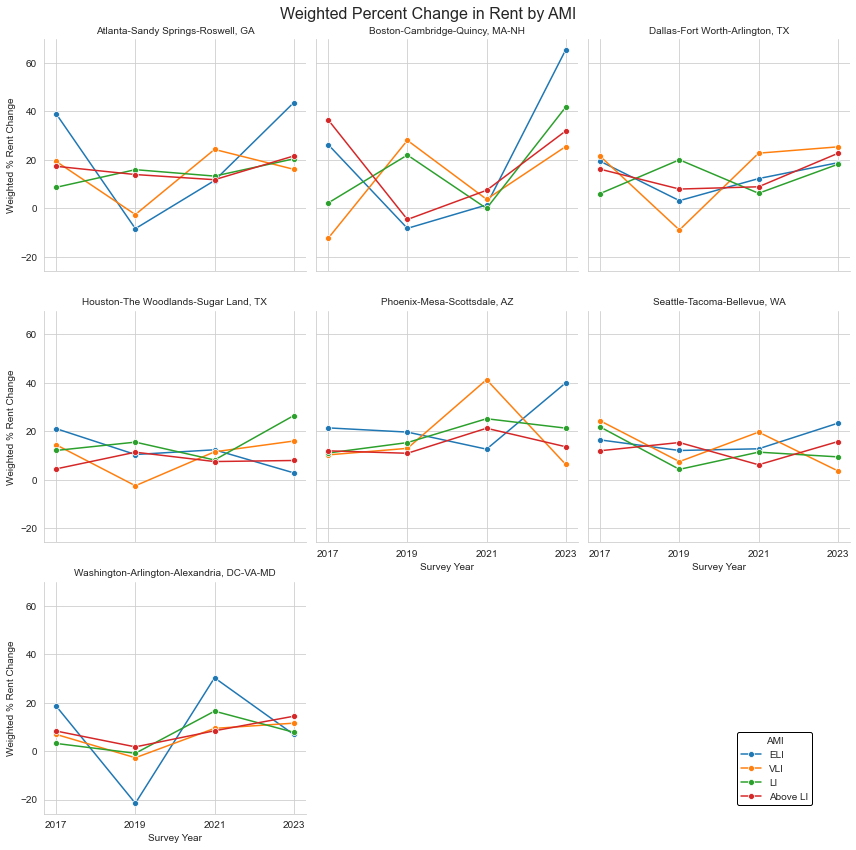

In [114]:
#Plot

g = sns.FacetGrid(
    agg, 
    col='Metro', 
    col_wrap=3, 
    height=4, 
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(sns.lineplot, x='SRVYEAR', y='rent_pct_change', marker='o')
g.set_titles("{col_name}")

# Set consistent axis labels
g.set_axis_labels("Survey Year", "Weighted % Rent Change")

# Set consistent x-ticks (for AHS: 2017, 2019, 2021, 2023)
for ax in g.axes.flat:
    ax.set_xticks([2017, 2019, 2021, 2023])
    ax.set_xticklabels([2017, 2019, 2021, 2023])

# Set a single legend for AMI categories
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI",
    loc='lower right',
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(0.95, 0.05)
)

#Title and layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Weighted Percent Change in Rent by AMI', fontsize=16)
plt.tight_layout()

#Save and export image as png file
#g.savefig('weighted_percent_rent_change_AMI.png', dpi=300, bbox_inches='tight')

plt.show()

### 6(b). Cumulative Rent Change Since 2015 by AMI

In [115]:
#Calculate baseline rent (2015) for each Metro–AMI
base_rent = (
    agg[agg['SRVYEAR'] == 2015]
    .set_index(['Metro', 'AMI'])['weighted_rent']
    .rename('base_rent')
)

In [116]:
#Merge base_rent into full dataframe
agg = agg.merge(base_rent, on=['Metro', 'AMI'], how='left')

In [117]:
#Calculate cumulative rent change relative to 2015
agg['cumulative_rent_change'] = (
    (agg['weighted_rent'] / agg['base_rent']) - 1
) * 100

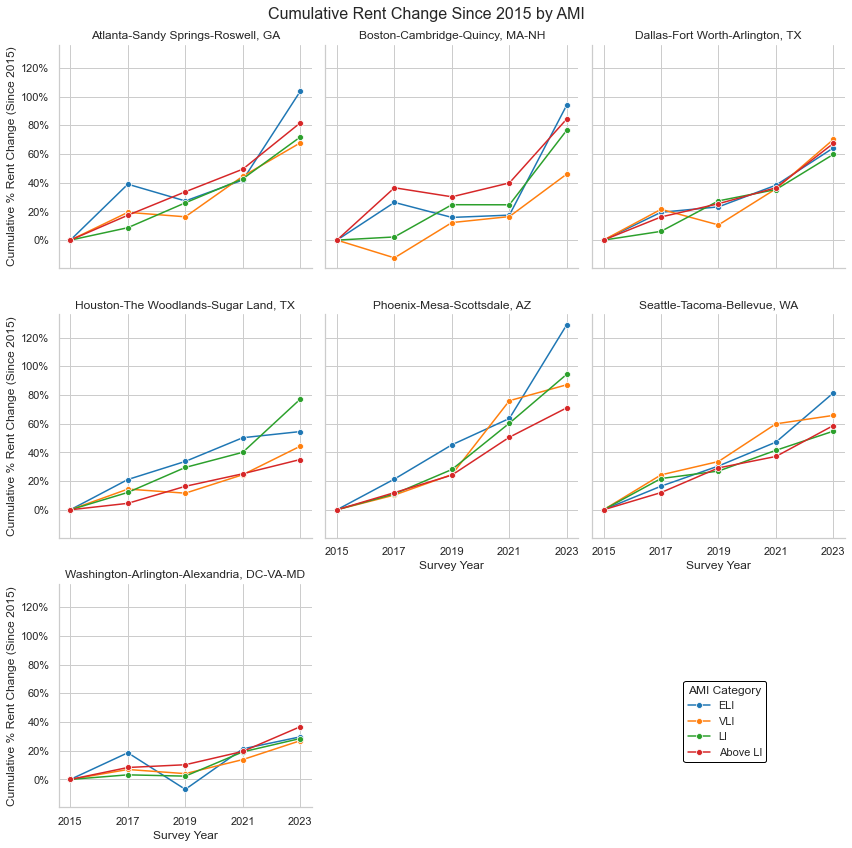

In [118]:
#Plot
sns.set(style="whitegrid")

g = sns.FacetGrid(
    agg,
    col='Metro',
    col_wrap=3,
    height=4,
    sharey=True,
    hue='AMI',
    palette='tab10'
)

g.map_dataframe(
    sns.lineplot,
    x='SRVYEAR',
    y='cumulative_rent_change',
    marker='o'
)

g.set_axis_labels("Survey Year", "Cumulative % Rent Change (Since 2015)")
g.set_titles("{col_name}")
g.set(xticks=[2015, 2017, 2019, 2021, 2023])

#Format y-axis as percentage
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(PercentFormatter(1.0 if agg['cumulative_rent_change'].max() < 1 else 100))

# Remove duplicate legends
for ax in g.axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.remove()

#Single shared legend
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles, labels,
    title="AMI Category",
    loc='lower right',
    bbox_to_anchor=(0.9, 0.1),
    frameon=True,
    edgecolor='black',
    framealpha=1
)

#Add overall title
g.fig.suptitle("Cumulative Rent Change Since 2015 by AMI", fontsize=16)
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.tight_layout()

#Save and export image as png file
#g.savefig('cumulative_rent_change.png', dpi=300, bbox_inches='tight')

plt.show()